# Определения цены автомобиля

### Задача:

Максимально быстро находить выгодные предложения по продажи автомобилей (купить ниже рынка - продать дороже рынка).
Компания просит создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам. Качественная модель сможет быстро выявлять выгодные предложения (когда желаемая цена продавца ниже предсказанной рыночной цены). Это значительно ускорит работу менеджеров и повысит прибыль компании. 

Данные собирались вручную с 2014 года, но количество данных не позволяет создать качественную модель.

### Описание данных (основные):

- bodyType - Тип кузова легкого автомобиля
- brand - Марка
- car_url - Ссылка (auto.ru)
- color - Цвет
- complectation_dict - Комплектация 
- description - Описание владельца
- engineDisplacement - Двигатель
- enginePower - Мощность
- equipment_dict - Харакетиристика
- fuelType - Тип топлива
- image - Картинка
- mileage - Пробег
- modelDate - Год выпуска модели
- model_info - Информация модели
- model_name - Модель
- name - Модель/Заголовок владельца
- numberOfDoors - Кол-во дверей
- parsing_unixtime - Время сбора информации
- priceCurrency - Валюта
- productionDate - Год выпуска автомобиля
- sell_id - ID записи (sample имеет цену авто)
- super_gen - Полная харакетирстика
- vendor - Страна производитель
- Владельцы - Кол-во владелцов
- Владение - Срок владения
- ПТС - Паспорт Транспортного Средства

# Этапы выполнения проекта

[1. Выгрузка библиотек, определение основных функций, выгрузка данных](#Point_1)<br>
[2. Предобработка](#Point_2)<br>
[3. Анализ предобработанных данных, Feature Engineering и подготовка выборок](#Point_3)<br>
[4. Подготовка выборок](#Point_4)<br>
[5. MachineLearning](#Point_5)<br>

<a id='Point_1'></a>
# 1. Выгрузка библиотек, определение основных функций, выгрузка данных.

## 1.1 Подключение библиотек и определение основных функций

Используем random seed для воссоздания результатов при повторном запуске. 

In [1]:
RANDOM_SEED = 44

Импортируем необходимые библиотеки и модули.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

#Библиотеки для парсинга, в случае необходимости дополнительной выгрузки
#from bs4 import BeautifulSoup 
#import requests

import re

import statsmodels.api as sm
from statsmodels.formula.api import ols

from statsmodels.stats.multicomp import pairwise_tukeyhsd

from scipy import stats
from scipy.stats import pearsonr
from sklearn.feature_selection import f_regression

from scipy.stats import (shapiro, probplot,
                         mannwhitneyu, ttest_ind,
                         pearsonr, f_oneway)

from itertools import combinations

#Токенизация
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA

from sklearn.metrics import mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor # Модель 2

from sklearn.ensemble import RandomForestRegressor # Модель 3

from sklearn.ensemble import ExtraTreesRegressor # Модель 4

from xgboost import XGBRegressor # Модель 5
from sklearn.ensemble import StackingRegressor # Модель 5
from sklearn.linear_model import LinearRegression # Модель 5

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leoge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Необходимые функции для предобработки, анализа и визуализации данных.
Уникальные функции будут выводиться перед использованием.

In [3]:
# Для удобства будем использовать заготовленную функцию и по мере продвижения менять название столбцов.
def rename_column(df, column, new_column):
    df.rename(columns = {column : new_column}, inplace = True)
    
    
# Проверка на отличие столбцах в датасетах.
def check_df(df1, df2):
    print('Columns in df1, but not in df2: ', list(set(df1.columns).difference(df2.columns)))
    print(f'df1 : df2')
    print()
    for col1 in df1.columns:
        for col2 in df2.columns: 
            if col1 == col2 and df1[col1].dtype != df2[col2].dtype:
                print(col1, df1[col1].dtype,' | ',col2, df2[col2].dtype)

# Проверка столбца
def check_unique(df, df_name,column, start, end):
    bold(df_name)
    print(f'Кол-во непустых строк в столбце: {len(df[column]) - df[column].isna().sum()}')
    print(f'Тип данных столбца: {df[column].dtype}')
    print(f'Пустых значений: {df[column].isna().sum()}')
    print(f'Кол-во уникальных значений: {len(df[column].unique())}')
    print()
    print(f'Пример уникальных значений: {df[column].unique()[start:end]}') 
    line()
                
'''                
# Првоерка столбца на количество пустых строк и уникальных значений.
def check_column(df, col):
    print(f'Пустых значений: {df[col].isna().sum()}')
    print(f'Кол-во строк в столбце: {len(df[col])}')
    print(f'Тип данных столбца: {df[col].dtype}')
    print()
    print(f'Кол-во уникальных значений: {len(df[col].unique())}')
    print(f'Уникальные значений: {df[col].unique()}')
    #print()
    #print(f'Уникальных значений: {set(df[col])}')
    print() 

'''

# Визуализация данных с помощью Boxplot (old)
def show_boxplot(data: pd.DataFrame, column: str, target_column: str):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y=target_column, 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index)],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

# Нахождение кванителей    
def quantile(df, col):
    Q1 = np.quantile(df[col], .25)
    Q3 = np.quantile(df[col], .75)
    IQR = Q3 - Q1

    left_border = Q1 - 1.5 * IQR
    right_border = Q3 + 1.5 * IQR
    
    left_outers = df[df[col] < left_border]
    right_outers = df[df[col] > right_border]
    print(f'"{col}" has {len(left_outers)} low outliers and {len(right_outers)} high outliers. Sum: {len(left_outers)+len(right_outers)}')

# Нахождение Z score
def z_score_outlier(df, col):
    outliers = []
    threshold = 3
    mean = df[col].mean()
    std = df[col].std()
    for e, i in enumerate(df[col]):
        z_score = ((i - mean) / std)
        if np.abs(z_score) > threshold:
            outliers.append(i)
    print(f'"{col}" Z-score shows {len(outliers)} outliers')

# Визуализация данных с помощью Boxplot
def boxplot(df, col):
    fig = plt.figure(figsize=(10,5))
    sns.boxplot(df[col])
    plt.title('Box Plot', fontsize=15)
    plt.xlabel(col, fontsize=14)
    plt.show()
    
    
# Метрика MAPE с использованием mean_absolute_percentage_error
# Версия с использованием MAPE из sklearn
def mape(y_true, y_pred):
    print(f'Mape: {(mean_absolute_percentage_error(y_true, y_pred)*100):0.2f}%')
    
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Вспомогательные функции
def bold(name):
    print()
    print('\033[1m'+name+'\033[0m')
    print()
    
def line():
    print('---------------------------------------------------------------------------------------------------------')

## 1.2 Импорт датасетов

### Информация:

* train - Датасет, который заполнялся вручную с 2014 по 2020 года.
* train_parsed - Запарсенные данные с сайта auto.ru. Год парсинга 2021 год. 
* test - Запарсенные данные с сайта auto.ru. Год парсинга 2020 год.
* sample - ID и цена авто на момент парсинга данных для датасета test.

In [4]:
train = pd.read_csv('all_auto_ru_09_09_2020.csv', low_memory = False)
train_parsed = pd.read_csv('train_df_full_part1.csv', low_memory = False)
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

## 1.3 Краткий анализ датасетов

Статистические показатели (числовые)

In [5]:
print('\033[1m'+'Датасет train'+'\033[0m')
display(train.describe())
print('\033[1m'+'Датасет train_parsed'+'\033[0m')
display(train_parsed.describe())
print('\033[1m'+'Датасет test'+'\033[0m')
display(test.describe())

Датасет train


,modelDate,numberOfDoors,productionDate,enginePower,mileage,Состояние,Владельцы,price,hidden
count,89377.000000,89377.000000,89378.000000,89377.000000,89378.000000,0.0,75790.000000,8.896800e+04,0.0
mean,2008.543294,4.510467,2010.832531,171.231637,134828.811497,NaN,2.233698,1.294586e+06,NaN
std,7.415436,0.653203,7.024776,83.527540,102979.784485,NaN,0.817455,1.950410e+06,NaN
min,1904.000000,0.000000,1904.000000,11.000000,0.000000,NaN,1.000000,1.600000e+04,NaN
25%,2005.000000,4.000000,2007.000000,115.000000,56042.500000,NaN,2.000000,3.500000e+05,NaN
50%,2009.000000,5.000000,2011.000000,150.000000,130000.000000,NaN,2.000000,6.500000e+05,NaN
75%,2014.000000,5.000000,2016.000000,199.000000,194939.750000,NaN,3.000000,1.480000e+06,NaN
max,2020.000000,5.000000,2020.000000,800.000000,1000000.000000,NaN,3.000000,9.900000e+07,NaN


Датасет train_parsed


,mileage,modelDate,model_info,numberOfDoors,parsing_unixtime,productionDate,sell_id,vendor,views,price
count,103034.000000,129986.000000,0.0,129987.000000,1.301540e+05,129988.000000,1.299690e+05,0.0,101998.000000,1.097650e+05
mean,116610.915407,2012.934578,NaN,4.643164,1.632842e+09,2015.083854,1.104866e+09,NaN,564.982284,2.801223e+06
std,85154.492046,6.017749,NaN,0.619354,1.316360e+05,5.929774,1.779786e+06,NaN,1814.036025,2.689068e+06
min,1.000000,1938.000000,NaN,2.000000,1.632613e+09,1952.000000,1.003139e+09,NaN,2.000000,2.300000e+04
25%,51000.000000,2010.000000,NaN,4.000000,1.632725e+09,2012.000000,1.104900e+09,NaN,127.000000,1.000000e+06
50%,100000.000000,2014.000000,NaN,5.000000,1.632821e+09,2016.000000,1.105219e+09,NaN,245.000000,2.045000e+06
75%,161000.000000,2017.000000,NaN,5.000000,1.632973e+09,2020.000000,1.105376e+09,NaN,511.000000,3.649000e+06
max,1000000.000000,2021.000000,NaN,5.000000,1.633049e+09,2021.000000,1.105403e+09,NaN,148149.000000,3.999000e+07


Датасет test


,mileage,modelDate,numberOfDoors,parsing_unixtime,productionDate,sell_id
count,34686.000000,34686.000000,34686.000000,3.468600e+04,34686.000000,3.468600e+04
mean,162009.767889,2007.074728,4.450816,1.603287e+09,2009.264602,1.098300e+09
std,100676.559489,7.415894,0.703040,1.493071e+05,7.047661,1.911225e+07
min,1.000000,1904.000000,0.000000,1.603107e+09,1904.000000,2.665000e+03
25%,91153.500000,2004.000000,4.000000,1.603221e+09,2006.000000,1.099049e+09
50%,149779.500000,2008.000000,5.000000,1.603254e+09,2011.000000,1.100911e+09
75%,215000.000000,2012.000000,5.000000,1.603290e+09,2014.000000,1.101245e+09
max,1000000.000000,2020.000000,5.000000,1.603710e+09,2020.000000,1.101375e+09


Статистические показатели (категориальные)

In [6]:
print('\033[1m'+'Датасет train'+'\033[0m')
display(train.describe(include = ['O', 'bool']))
print('\033[1m'+'Датасет train_parsed'+'\033[0m')
display(train_parsed.describe(include = ['O', 'bool']))
print('\033[1m'+'Датасет test'+'\033[0m')
display(test.describe(include = ['O', 'bool']))

Датасет train


,bodyType,brand,color,fuelType,name,vehicleConfiguration,vehicleTransmission,engineDisplacement,description,Комплектация,Привод,Руль,ПТС,Таможня,Владение,start_date,model
count,89377,89378,89378,89378,89377,89377,89377,89377,86124,89378,89377,89378,89017,89378,29201,89378,89378
unique,168,36,16,6,4484,1860,4,534,77568,5839,3,2,2,1,290,75680,1086
top,Внедорожник 5 дв.,MERCEDES,040001,бензин,2.0 AT (150 л.с.),SEDAN MECHANICAL 1.6,AUTOMATIC,1.6,РОЛЬФ Северо-Запад - это первый мегамолл автом...,{'id': '0'},передний,LEFT,ORIGINAL,True,"{'year': 2018, 'month': 10}",2020-09-01T10:01:11Z,FOCUS
freq,31885,8012,25212,75053,1610,4166,49218,17032,246,59130,47315,87589,78597,89378,497,93,2467


Датасет train_parsed


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,date_added,region
count,129986,129988,129969,129988,105267,129988,129988,129988,129969,129986,...,129986,103034,14286,103034,103032,103033,103032,103030,103034,103034
unique,21,12,40721,16,2348,35274,52,307,31190,5,...,4,3,261,2,3,2,1,1,939,1335
top,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/rav_4/21...,чёрный,"['cruise-control', 'multi-wheel', 'airbag-pass...",Официальный дилер Mercedes Benz ООО РОЛЬФ фили...,2.0 LTR,249 N12,{},бензин,...,автоматическая,1 владелец,3 года и 2 месяца,Оригинал,полный,Левый,Не требует ремонта,Растаможен,25 сентября,в Москве
freq,75068,20117,428,42216,1979,3230,36933,14262,8214,100407,...,73836,40576,646,92587,58563,99356,103032,103030,44873,39180


Датасет test


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
count,34686,34686,34686,34686,6418,34686,34686,34686,24690,34686,...,34686,34686,34686,34686,11995,34685,34686,34686,34686,34686
unique,24,12,34686,16,2364,31732,55,315,23705,5,...,634,4,2,3,275,2,3,2,1,1
top,седан,BMW,https://auto.ru/cars/used/sale/nissan/qashqai/...,чёрный,"{""id"":""4562904"",""name"":""Elegance"",""available_o...",Выгода до 82 000 руб. при обмене на Ваш автомо...,2.0 LTR,249 N12,"{""leather"":true}",бензин,...,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,EUROPEAN,3 или более,1 год и 10 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен
freq,13147,4473,1,11010,51,264,7391,1708,108,28601,...,2389,19596,20682,15957,209,30098,15565,33287,34686,34686


In [7]:
# Отсортируем столбцы, перед просмотром
#train = train.sort_index(axis=1)
#train_parsed = train_parsed.sort_index(axis=1)
#test = test.sort_index(axis=1)

Кол-во ненулевых записей по признакам и их тип данных.

In [8]:
print('\033[1m'+'Датасет train'+'\033[0m')
print(train.info())
line()
print('\033[1m'+'Датасет test'+'\033[0m')
print(test.info())
line()
print('\033[1m'+'Датасет train_parsed'+'\033[0m')
print(train_parsed.info())
line()

Датасет train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Приво

Столбцы в датасетах.

In [9]:
bold('train')
print(train.columns.sort_values())
print()
line()
bold('train_parsed')
print(train_parsed.columns.sort_values())
print()
line()
bold('test')
print(test.columns.sort_values())


train

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'hidden', 'mileage', 'model', 'modelDate',
       'name', 'numberOfDoors', 'price', 'productionDate', 'start_date',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение',
       'Комплектация', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня'],
      dtype='object')

---------------------------------------------------------------------------------------------------------

train_parsed

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'date_added', 'description', 'engineDisplacement', 'enginePower',
       'equipment_dict', 'fuelType', 'image', 'mileage', 'modelDate',
       'model_info', 'model_name', 'name', 'numberOfDoors', 'parsing_unixtime',
       'price', 'priceCurrency', 'productionDate', 'region', 'sell_id',
       'super_gen', 'vehicleConfiguration', 'vehicleTransmission', 'vendor',
       'views', 'Владельцы', '

Отличия между датасетами (столбцы).

In [10]:
bold('train & test')
check_df(train, test)
line()
bold('train_parsed & test')
print(check_df(train_parsed, test))
line()
bold('train & train_parsed')
print(check_df(train, train_parsed))


train & test

Columns in df1, but not in df2:  ['hidden', 'Комплектация', 'model', 'price', 'start_date']
df1 : df2

modelDate float64  |  modelDate int64
numberOfDoors float64  |  numberOfDoors int64
enginePower float64  |  enginePower object
Состояние float64  |  Состояние object
Владельцы float64  |  Владельцы object
Таможня bool  |  Таможня object
---------------------------------------------------------------------------------------------------------

train_parsed & test

Columns in df1, but not in df2:  ['region', 'date_added', 'views', 'price']
df1 : df2

mileage float64  |  mileage int64
modelDate float64  |  modelDate int64
model_info float64  |  model_info object
numberOfDoors float64  |  numberOfDoors int64
parsing_unixtime float64  |  parsing_unixtime int64
productionDate float64  |  productionDate int64
sell_id float64  |  sell_id int64
vendor float64  |  vendor object
None
---------------------------------------------------------------------------------------------------

In [11]:
print(f"Количество столбцов в train: {len(train.columns)}, количество строк: {len(train)}")
print(f"Количество столбцов в test: {len(test.columns)}, количество строк: {len(test)}")
print(f"Количество столбцов в sample: {len(sample.columns)}, количество строк: {len(sample)}")
print(f"Количество столбцов в train_parsed: {len(train_parsed.columns)}, количество строк: {len(train_parsed)}")

Количество столбцов в train: 26, количество строк: 89378
Количество столбцов в test: 32, количество строк: 34686
Количество столбцов в sample: 2, количество строк: 34686
Количество столбцов в train_parsed: 36, количество строк: 130201


In [12]:
#Сортируем столбцы
train = train.reindex(sorted(train.columns), axis=1)
train_parsed = train_parsed.reindex(sorted(train_parsed.columns), axis=1)
test = test.reindex(sorted(test.columns), axis=1)

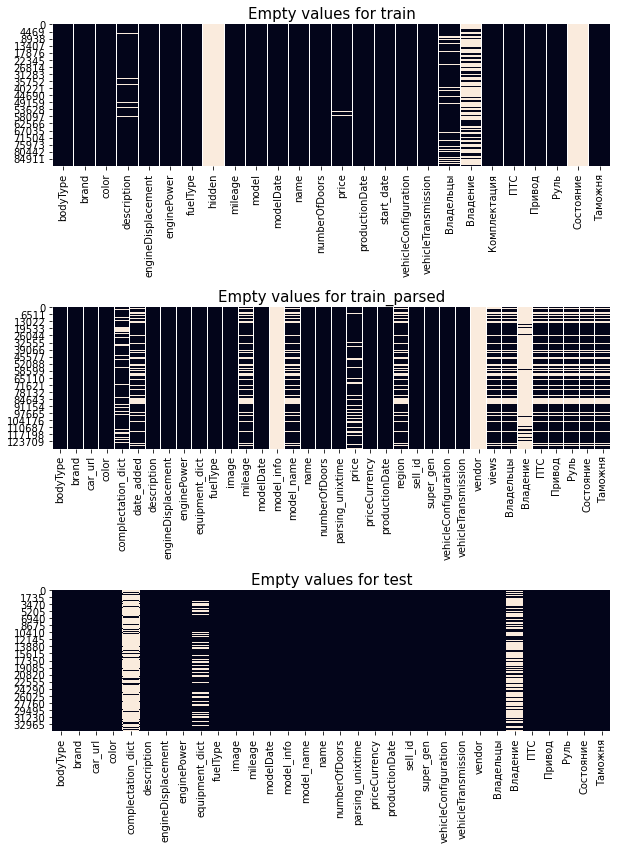

In [13]:
# Проверим отсутствующие значения в столбцах по датасетам
fig, axes = plt.subplots(3,1, figsize=(10, 13))
df_count = 0
df_name = ['train', 'train_parsed', 'test']
for df in [train, train_parsed, test]:
    sns.heatmap(df.isna(), ax=axes[df_count],
                    cbar = False)
    axes[df_count].set_title(f'Empty values for {df_name[df_count]}',
                          size=15)
    df_count += 1
plt.subplots_adjust(hspace=1);

In [14]:
first_train = train.copy()
first_train_parsed = train_parsed.copy()
first_test = test.copy()

<a id="Point_2"></a>
# 2. Предобработка

### 2.1 bodyType

In [15]:
check_unique(train, 'train', 'bodyType', 0, 10)
check_unique(train_parsed, 'train_parsed', 'bodyType', 0, 10)
check_unique(test, 'test', 'bodyType', 0, 10)


train

Кол-во непустых строк в столбце: 89377
Тип данных столбца: object
Пустых значений: 1
Кол-во уникальных значений: 169

Пример уникальных значений: ['Седан' 'Универсал 5 дв.' 'Хэтчбек 5 дв. Sportback' 'Хэтчбек 3 дв.'
 'Хэтчбек 5 дв.' 'Кабриолет' 'Купе' 'Лифтбек Sportback' 'Лифтбек'
 'Седан Long']
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 129986
Тип данных столбца: object
Пустых значений: 215
Кол-во уникальных значений: 22

Пример уникальных значений: ['лифтбек' 'внедорожник 5 дв.' 'компактвэн' 'хэтчбек 5 дв.'
 'универсал 5 дв.' 'седан' nan 'купе' 'хэтчбек 3 дв.' 'кабриолет']
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 24

Пример уникальных значений: ['лифтбек' 'внедорожник 5 дв.' 'хэтчбек 5 

In [16]:
# Проверяем данные с пустыми значениями в столбце bodyType.
for df in [train, train_parsed]:
    display(df[df['bodyType'].isna()])

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,hidden,mileage,model,...,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,Комплектация,ПТС,Привод,Руль,Состояние,Таможня
24624,NaN,HONDA,CACECB,"Продаю Honda Civic Suttle 1989 г. выпуска, неу...",NaN,NaN,универсал,NaN,400000,CIVIC,...,NaN,NaN,3.0,NaN,"{'id': '0', 'name': ''}",ORIGINAL,NaN,LEFT,NaN,True


,bodyType,brand,car_url,color,complectation_dict,date_added,description,engineDisplacement,enginePower,equipment_dict,...,vehicleTransmission,vendor,views,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
2305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# В датасетах train и train_parsed есть пустые значения, которые можно удалить.
train.dropna(subset = ['bodyType'], axis = 0, inplace = True)
train_parsed.dropna(subset = ['bodyType'], axis = 0, inplace = True)

In [18]:
# Преобразуем данные в столбце bodyType, задав нижний регистер, отделив первые элемент и удалив лишнее. 
for df in [train, train_parsed, test]:
    df['bodyType'] = df['bodyType'].apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)

In [19]:
#train['bodyType'] = train.bodyType.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)
#train_parsed['bodyType'] = train_parsed.bodyType.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)
#test['bodyType'] = test.bodyType.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)

In [20]:
# Проверяем столбец.
check_unique(train, 'train', 'bodyType', 0, 10)
check_unique(train_parsed, 'train_parsed', 'bodyType', 0, 10)
check_unique(test, 'test', 'bodyType', 0, 10)


train

Кол-во непустых строк в столбце: 89377
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 18

Пример уникальных значений: ['седан' 'универсал' 'хэтчбек' 'кабриолет' 'купе' 'лифтбек' 'внедорожник'
 'компактвэн' 'купе-хардтоп' 'родстер']
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 129986
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 16

Пример уникальных значений: ['лифтбек' 'внедорожник' 'компактвэн' 'хэтчбек' 'универсал' 'седан' 'купе'
 'кабриолет' 'родстер' 'минивэн']
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 18

Пример уникальных значений: ['лифтбек' 'внедорожник' 'хэтчбек' 'седан' 'компактвэн' 'универсал'
 'пикап' 'купе' 'кабриолет' 'ми

In [21]:
for df in [train, train_parsed, test]:
    df.rename(columns = {'bodyType':'body_type'}, inplace = True)

### 2.2 brand

In [22]:
check_unique(train, 'train', 'brand', 0, 10)
check_unique(train_parsed, 'train_parsed', 'brand', 0, 10)
check_unique(test, 'test', 'brand', 0, 10)


train

Кол-во непустых строк в столбце: 89377
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 36

Пример уникальных значений: ['AUDI' 'BMW' 'CADILLAC' 'CHERY' 'CHEVROLET' 'CHRYSLER' 'CITROEN' 'DAEWOO'
 'DODGE' 'FORD']
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 129986
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 12

Пример уникальных значений: ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS']
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 12

Пример уникальных значений: ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS']
------------------------------------------------------

In [23]:
# Сравним совпадение по строкам в датасете test с датасетами train и train_parsed.
bold('train & test')
print(f'В train {len(train[train.brand.isin(test.brand.unique())])} строк из {len(train)} сходятся по бренду.')
print(f'Что составляет {round((len(train[train.brand.isin(test.brand.unique())]) / len(train)) * 100, 2)}% изначального датасета.')
print()
line()
bold('train_parsed & test')
print(f'В train_parsed {len(train_parsed[train_parsed.brand.isin(test.brand.unique())])} строк из {len(train_parsed)} сходятся по бренду.')
print(f'Что составляет {round((len(train_parsed[train_parsed.brand.isin(test.brand.unique())]) / len(train_parsed)) * 100, 2)}% изначального датасета.')


train & test

В train 49308 строк из 89377 сходятся по бренду.
Что составляет 55.17% изначального датасета.

---------------------------------------------------------------------------------------------------------

train_parsed & test

В train_parsed 129986 строк из 129986 сходятся по бренду.
Что составляет 100.0% изначального датасета.


In [24]:
# Используем только нужные нам строки.
train = train[train.brand.isin(test.brand.unique())]
train_parsed = train_parsed[train_parsed.brand.isin(test.brand.unique())]

### 2.3 color

In [25]:
# Проверим столбцы и кол-во уникальных значений
check_unique(train, 'train', 'color', 0, 10)
check_unique(train_parsed, 'train_parsed', 'color', 0, 10)
check_unique(test, 'test', 'color', 0, 10)


train

Кол-во непустых строк в столбце: 49308
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 16

Пример уникальных значений: ['040001' 'EE1D19' '0000CC' 'CACECB' '007F00' 'FAFBFB' '97948F' '22A0F8'
 '660099' '200204']
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 129986
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 16

Пример уникальных значений: ['белый' 'синий' 'серый' 'чёрный' 'серебристый' 'бежевый' 'красный'
 'коричневый' 'оранжевый' 'пурпурный']
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 16

Пример уникальных значений: ['синий' 'чёрный' 'серый' 'коричневый' 'белый' 'пурпурный' 'бежевый'
 'серебристый' 'красный' 'зелёный']
-----------------

In [26]:
# Переименнуем вручную цвета 
train['color'].replace(to_replace={'040001' : 'чёрный', 'EE1D19': 'красный', '0000CC' : 'синий', 'CACECB': 'серебристый',
                                   '007F00' : 'зелёный', 'FAFBFB' : 'белый', '97948F' : 'серый', '22A0F8' : 'голубой', 
                                   '660099' : 'пурпурный', '200204' : 'коричневый', 'C49648' : 'бежевый', 
                                   'DEA522' : 'золотистый', '4A2197' : 'фиолетовый', 'FFD600' : 'жёлтый',
                                   'FF8649' : 'оранжевый', 'FFC0CB' : 'розовый'}, inplace = True)

### 2.4 description

In [27]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'description', 0, 1)
check_unique(train_parsed, 'train_parsed', 'description', 0, 1)
check_unique(test, 'test', 'description', 0, 1)


train

Кол-во непустых строк в столбце: 47720
Тип данных столбца: object
Пустых значений: 1588
Кол-во уникальных значений: 41876

Пример уникальных значений: [' Машина  в приличном состоянии ,не гнилая не ржавая .По менины этим  летом коренные  и шатунные вкладыши .Масло не ест .  Цвет черный .Год выпуска 1991.Двигатель 2.8.Привод полный кватро.Все стеклоподъемники .Кожаный салон  .   ']
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 129986
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 35272

Пример уникальных значений: ['Автомобиль приобретался у официального дилера Оригинальный ПТС Дополнительные опции Обогрев всех сидений Биксеноновая головная оптика Датчики дождя и света Двухзонный климат контроль Круиз контроль Передние и задние датчики парковки Дополнительное оборудование Сигнализация с автозапуском 007944 Кредит от 8 Первоначальный взнос от 0 Бо

In [28]:
#Вместо токенизации проведем обычный отбор. Почему был выбран такой способ - Большое разнообразие используемых слов. 
#Сленг не гарант качества, но и передать эстафету в руки метафоричному описанию нельзя.
display(train['description'][0])
display(train['description'][33])
#Зато ключевые слова дадут больше ясности, что можем влиять на цену.

' Машина  в приличном состоянии ,не гнилая не ржавая .По менины этим  летом коренные  и шатунные вкладыши .Масло не ест .  Цвет черный .Год выпуска 1991.Двигатель 2.8.Привод полный кватро.Все стеклоподъемники .Кожаный салон  .   '

'Двигатель работает идеально, коробка автомат, работает идеально, кузов без ржавчины и сколов, машина без проблем сел и поехал, резина лето, зима(на дисках), подвеска перебрана полностью перед и зад, сзади менялись даже сайлентблоки на балке, выхлопная система новая, продаётся по причине покупки другого автомобиля. С хорошим торгом.'

Описание придает не только вес публикации, но и может ответить на интересующие вопросы клиента.
Необходимо почистить записи и посчитать количество предложений. 
Хотя встречаются и списки, мы будем их пункты как отделное предложение считать. Тут же ремарка о наличии автосаланов, которые отличаются большим количеством текста в описании.

In [29]:
# Не станем удалять этот признак, т.к. подсчитаем кол-во слов и выведем новый признак (воспользуемся алгоритмами TF-IDF и w2v)
# Пустые значения будем считать как отсутствие описания, что может привести к уменьшению цены.

In [30]:
# Удаляем блок, т.к. информации много и капаться в ней будет, возможно, не так выгодно.
#train.drop('description', axis = 1, inplace = True)
#train_parsed.drop('description', axis = 1, inplace = True)
#test.drop('description', axis = 1, inplace = True)

### 2.5 engineDisplacement

In [31]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'engineDisplacement', 0, 10)
check_unique(train_parsed, 'train_parsed', 'engineDisplacement', 0, 10)
check_unique(test, 'test', 'engineDisplacement', 0, 10)


train

Кол-во непустых строк в столбце: 49308
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 411

Пример уникальных значений: ['2.8' '1.8' '2.3' '2.0' '2.6' '2.2' 'S4' '2.0d' '2.5d' '1.9']
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 129986
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 52

Пример уникальных значений: ['1.8 LTR' '1.6 LTR' '1.4 LTR' '1.2 LTR' '2.0 LTR' '3.6 LTR' '1.5 LTR'
 '1.9 LTR' '1.3 LTR' '2.8 LTR']
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 55

Пример уникальных значений: ['1.2 LTR' '1.6 LTR' '1.8 LTR' '2.0 LTR' '1.4 LTR' '1.3 LTR' '1.0 LTR'
 '3.6 LTR' '1.5 LTR' '1.9 LTR']
----------------------------------------------------

In [32]:
# Функция для конвертации данных объема двигателя в тип данных float.
def engineDisplacement_to_float(row):
    re_find = re.findall('\d\.\d', str(row))
    if re_find:
        return float(re_find[0])
    return None

In [33]:
train['engineDisplacement'] = train.name.apply(
                                engineDisplacement_to_float)

In [34]:
for df in [train_parsed, test]:
    df['engineDisplacement'] = df.engineDisplacement.apply(
                                lambda x: x.replace(" LTR", "0.0 LTR") if x == " LTR" else x).apply(
                                lambda x: float(x.replace("LTR", "")) if isinstance(x, str) else x)

In [35]:
#Есть предположение, что объем двигателя с пустым значениям - электромобиль.
print(f"Тип топлива у пустых значений: {train['fuelType'].loc[train['engineDisplacement'].isna()].unique()}. Кол-во: {len(train['fuelType'].loc[train['engineDisplacement'].isna()])}")
print(f"Тип топлива у ноль значений и их кол-во: {train['fuelType'].loc[train['engineDisplacement'] == 0.0].unique()}. Кол-во: {len(train['fuelType'].loc[train['engineDisplacement'] == 0.0])}")

Тип топлива у пустых значений: ['электро']. Кол-во: 94
Тип топлива у ноль значений и их кол-во: ['электро']. Кол-во: 2


In [36]:
# Отсутствующие значения в train.engineDisplacement - электромобиль. Заменяем значения на ноль, как в test. 
train.loc[(train['engineDisplacement'].isna()) & (train['fuelType'] == 'электро'), 'engineDisplacement'] = 0.0

In [37]:
#train.dropna(subset = ['engineDisplacement'], axis = 0, inplace = True)

In [38]:
for df in [train, train_parsed, test]:
    df.rename(columns = {'engineDisplacement':'engine_displacement'}, inplace = True)

### 2.6 enginePower

In [39]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'enginePower', 0, 10)
check_unique(train_parsed, 'train_parsed', 'enginePower', 0, 10)
check_unique(test, 'test', 'enginePower', 0, 10)


train

Кол-во непустых строк в столбце: 49308
Тип данных столбца: float64
Пустых значений: 0
Кол-во уникальных значений: 316

Пример уникальных значений: [174.  90. 136. 101. 133. 150. 115. 137. 112. 230.]
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 129986
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 306

Пример уникальных значений: ['180 N12' '110 N12' '90 N12' '150 N12' '105 N12' '125 N12' '152 N12'
 '102 N12' '70 N12' '80 N12']
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 315

Пример уникальных значений: ['105 N12' '110 N12' '152 N12' '200 N12' '102 N12' '150 N12' '90 N12'
 '180 N12' '220 N12' '122 N12']
----------------------------------------------------------------

In [40]:
train_parsed['enginePower'] = train_parsed['enginePower'].apply(
    lambda x: None if x == 'undefined N12' else float(str(x).replace(' N12', '')))

test['enginePower'] = test['enginePower'].apply(lambda x: float(x.split(' ')[0]))

In [41]:
#train_parsed.dropna(subset = ['enginePower'], axis = 0, inplace = True)

In [42]:
#Задаем нужный тип данных столбцам
for df in [train, train_parsed, test]:
    df['enginePower'] = df['enginePower'].astype(np.int64)

In [43]:
for df in [train, train_parsed, test]:
    df.rename(columns = {'enginePower':'engine_power'}, inplace = True)

### 2.7 fuelType

In [44]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'fuelType', 0, 10)
check_unique(train_parsed, 'train_parsed', 'fuelType', 0, 10)
check_unique(test, 'test', 'fuelType', 0, 10)


train

Кол-во непустых строк в столбце: 49308
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 5

Пример уникальных значений: ['бензин' 'дизель' 'электро' 'гибрид' 'газ']
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 129986
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 5

Пример уникальных значений: ['бензин' 'дизель' 'электро' 'гибрид' 'газ']
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 5

Пример уникальных значений: ['бензин' 'дизель' 'гибрид' 'электро' 'газ']
---------------------------------------------------------------------------------------------------------


In [45]:
for df in [train, train_parsed, test]:
    df.rename(columns = {'fuelType':'fuel_type'}, inplace = True)

### 2.8 hidden

In [46]:
check_unique(train, 'train', 'hidden', 0, 10)


train

Кол-во непустых строк в столбце: 0
Тип данных столбца: float64
Пустых значений: 49308
Кол-во уникальных значений: 1

Пример уникальных значений: [nan]
---------------------------------------------------------------------------------------------------------


In [47]:
train.drop('hidden', axis = 1, inplace = True)

### 2.9 mileage

In [48]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'mileage', 0, 10)
check_unique(train_parsed, 'train_parsed', 'mileage', 0, 10)
check_unique(test, 'test', 'mileage', 0, 10)


train

Кол-во непустых строк в столбце: 49308
Тип данных столбца: int64
Пустых значений: 0
Кол-во уникальных значений: 9787

Пример уникальных значений: [350000 173424 230000 240000 300000 200000 323000 371200 456000 140000]
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 103032
Тип данных столбца: float64
Пустых значений: 26954
Кол-во уникальных значений: 15182

Пример уникальных значений: [162026.  19210.     nan  52400.  44000.  17895.  10836.  18056. 109100.
 137649.]
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: int64
Пустых значений: 0
Кол-во уникальных значений: 11268

Пример уникальных значений: [ 74000  60563  88000  95000  58536 172000 107000 226706   9706  37361]
------------------------------------------------------------------------------------

In [49]:
train_parsed['mileage'] = train_parsed.mileage.fillna(0.0).astype(np.int64)

In [50]:
# Меняем значения в датасете test в столбце mileage. Т.к. 1 - не может быть.
# Далее mileage может нам помочь в определении новое авто или с пробегом. (меняем цену подстать данным)
# test['mileage'] = test.mileage.apply(lambda x: 0 if x == 1 else x).sort_values()

### 2.10 model

In [51]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'model', 0, 10)
check_unique(train_parsed, 'train_parsed', 'model_name', 0, 10)
check_unique(test, 'test', 'model_name', 0, 10)


train

Кол-во непустых строк в столбце: 49308
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 554

Пример уникальных значений: ['100' '200' '80' '90' '920' 'A1' 'A2' 'A3' 'A4' 'A4_ALLROAD']
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 103032
Тип данных столбца: object
Пустых значений: 26954
Кол-во уникальных значений: 515

Пример уникальных значений: ['Octavia' 'Rapid' nan 'Karoq' 'Yeti' 'Superb' 'Kodiaq' 'Roomster' 'Fabia'
 'Felicia']
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 544

Пример уникальных значений: ['OCTAVIA' 'SUPERB' 'OCTAVIA_RS' 'YETI' 'KODIAQ' 'RAPID' 'FABIA'
 'ROOMSTER' 'FELICIA' 'KAROQ']
---------------------------------------------------------------------

#### Function

In [52]:
# Заполнение название модели
def fill_model_name(all_model_names: list, name: str):
    name = name.lower()
    if isinstance(name, str):
        if "RS Q8".lower() in name:
            return 'Q8'
        elif "QX55".lower() in name:
            return "QX55"
        try:
            value = name.split()
        except:
            return None
        if value[1] in all_model_names:
            return value[1]
        try:
            joined_value = "_".join([value[1], value[2]])
        except IndexError:
            return None
        if joined_value in all_model_names:
            return f"{value[1]}_{value[2]}"
        elif joined_value.replace('_', ' ') in all_model_names:
            return f"{value[1]} {value[2]}"
    return None

In [53]:
#Меняем название столбца для удобства.
train.rename(columns = {'model' : 'model_name'}, inplace = True)

In [54]:
train_parsed_original = train_parsed.copy()

In [55]:
train_parsed = train_parsed_original.copy()

### Способ 1

In [56]:
#Необходимо заполнить пустые значения модели авто.
#Для этого будем использовать столбец model_info из датасета test.
print(f"Кол-во пропущенных значений в test model_info: {test.model_info.isna().sum()}")
print(f"Кол-во пропущенных значений в test model_name: {test.model_name.isna().sum()}")

Кол-во пропущенных значений в test model_info: 0
Кол-во пропущенных значений в test model_name: 0


#### Подготовляем данные из test

In [57]:
# Забираем нужную информацию из test.model_info - Полное название модели: Сокращенное название
test['model_full'] = test.model_info.apply(lambda x: re.findall(r',"name":"(.+?)","ru_name',x)[0])
test['model_short'] = test.model_info.apply(lambda x: re.findall(r'code"'":"'"(.+?)"'","'"name',x)[0])
model_info_dict = {b:v for b,v in test.groupby(['model_full', 'model_short']).name.count().index}

#### Используем полученные данные и отбрасываем ненужные нам столбцы

In [58]:
# Использование словаря для определения модели в train_parsed.model_name
train_parsed['model_short'] = train_parsed.model_name.map(model_info_dict)

# Удалям лишние столбцы: предыдущий model_name из train_parsed
train_parsed.drop(['model_name'], axis = 1, inplace = True)

# Удалям лишние столбцы: model_full, model_short из test
test.drop(['model_full', 'model_short'], axis = 1, inplace = True)

# Переименнуем новый столбец model_short в model_name
train_parsed.rename(columns={'model_short': 'model_name'}, inplace=True)

# Удалям лишние столбцы: model_info из train_parsed
train_parsed.drop(['model_info'], axis = 1, inplace = True)

In [59]:
#Как мы видим, много пустых значений все еще осталось
train_parsed.model_name.isna().value_counts()

False    102722
True      27264
Name: model_name, dtype: int64

#### Используем уникальный список

In [60]:
# Сохраняем все доступные уникальные значения из 
#available_model_names = list(train_parsed.model_name.str.lower().unique())

available_model_names = list(train.model_name.append(
                        [train_parsed['model_name'], test['model_name']]).reset_index(drop=True).str.lower().unique())

In [61]:
#Используя столбец name и подготовленную функцию - мы выведем часть недостающих значений.
train_parsed.loc[train_parsed.model_name.isna(), 'model_name'] = train_parsed[train_parsed.model_name.isna()].name.apply(
     lambda x: fill_model_name(available_model_names, x))
train_parsed.model_name = train_parsed.model_name.str.lower().str.replace('_', ' ')

In [62]:
#Как мы видим, много пустых значений все еще осталось
train_parsed.model_name.isna().value_counts()

False    119897
True      10089
Name: model_name, dtype: int64

### Способ 2

In [63]:
train_parsed = train_parsed_original.copy()

In [64]:
#Чтобы NaN значения не мешали преобразованию - заполним их значением "Неизвестно"
train_parsed['super_gen'] = train_parsed.super_gen.fillna('Unknown')

In [65]:
#Используем столбец super_gen, чтобы выцепить нужные нам значения.
train_parsed['model_short'] = train_parsed.super_gen.apply(lambda x: re.findall(r", 'model': '(.+?)', 'modelName",x))
train_parsed['model_short'] = train_parsed['model_short'].apply(lambda x: str((str(x).replace("['", "")).replace("']", "")).replace("[]", ""))
train_parsed['model_short'] = train_parsed['model_short'].apply(lambda x: None if x == '' else x)
train_parsed['model_name'] = train_parsed['model_short']
train_parsed.drop(columns = ['model_short'], inplace = True)

In [66]:
train_parsed.dropna(subset=['model_name'], inplace = True)

In [67]:
#Как мы видим, много пустых значений все еще осталось
train_parsed.model_name.isna().value_counts()
#Будем использовать второй способ

False    129967
Name: model_name, dtype: int64

In [68]:
#Ставим нижний регистер для всех значений
for df in [train_parsed, train, test]:
    df['model_name'] = df['model_name'].apply(lambda x: str(x).lower())

In [69]:
#Проверяем значения
print(f"Кол-во несовпадающих моделей в датасетах train: {len(train.loc[~train['model_name'].isin(test['model_name']), 'model_name'])}")
print(f"Кол-во несовпадающих моделей в датасетах train_parsed: {len(train_parsed.loc[~train_parsed['model_name'].isin(test['model_name']), 'model_name'])}")

Кол-во несовпадающих моделей в датасетах train: 68
Кол-во несовпадающих моделей в датасетах train_parsed: 512


In [70]:
#Т.к. есть отличия в модели - лучше избавиться от записей с несовпадающими значениями
train = train[train.model_name.isin(test.model_name.unique())]
train_parsed = train_parsed[train_parsed.model_name.isin(test.model_name.unique())]

In [71]:
#train_parsed['model_name'].fillna('Unknown', inplace = True)

In [72]:
#train_parsed.dropna(subset = ['model_name'], axis = 0, inplace = True)

### 2.11 modelDate

In [73]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'modelDate', 'modelDate', 0, 10)
check_unique(train_parsed, 'modelDate', 'modelDate', 0, 10)
check_unique(test, 'test', 'modelDate', 0, 10)


modelDate

Кол-во непустых строк в столбце: 49240
Тип данных столбца: float64
Пустых значений: 0
Кол-во уникальных значений: 66

Пример уникальных значений: [1990. 1982. 1988. 1976. 1983. 1979. 1986. 1991. 1978. 1987.]
---------------------------------------------------------------------------------------------------------

modelDate

Кол-во непустых строк в столбце: 129455
Тип данных столбца: float64
Пустых значений: 0
Кол-во уникальных значений: 52

Пример уникальных значений: [2013. 2020. 2017. 2012. 2008. 2016. 2010. 2009. 2015. 2019.]
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: int64
Пустых значений: 0
Кол-во уникальных значений: 66

Пример уникальных значений: [2013 2017 2008 2009 2016 2012 2015 2010 2006 2000]
---------------------------------------------------------------------------------------------------------


In [74]:
train['modelDate'] = train['modelDate'].astype(np.int64)
train_parsed['modelDate'] = train_parsed['modelDate'].astype(np.int64)

In [75]:
#test['modelDate'] = test['modelDate'].astype(float)

In [76]:
for df in [train, train_parsed, test]:
    df.rename(columns = {'modelDate':'model_date'}, inplace = True)

### 2.12 complectation_dict

In [77]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'Комплектация', 0, 1)
check_unique(train_parsed, 'train_parsed', 'complectation_dict', 0, 1)
check_unique(test, 'test', 'complectation_dict', 0, 1)


train

Кол-во непустых строк в столбце: 49240
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 2892

Пример уникальных значений: ["{'id': '0'}"]
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 104972
Тип данных столбца: object
Пустых значений: 24483
Кол-во уникальных значений: 2321

Пример уникальных значений: ["['cruise-control', 'multi-wheel', 'xenon', 'heated-wash-system', 'airbag-passenger', 'lock', 'door-sill-panel', 'electro-mirrors', 'mirrors-heat', 'volume-sensor', 'cooling-box', 'seat-memory', 'start-stop-function', 'automatic-lighting-control', 'computer', 'seat-transformation', 'light-cleaner', 'airbag-side', 'abs', 'wheel-leather', 'climate-control-1', 'auto-mirrors', 'esp', 'adaptive-light', 'usb', 'audiopreparation', 'ashtray-and-cigarette-lighter', 'front-centre-armrest', 'servo', 'electro-window-back', '17-inch-wheels', 'park-assist-f', 'co

In [78]:
train.drop(['Комплектация'], axis = 1, inplace = True)

for df in [train_parsed, test]:
    df.drop(['complectation_dict'], axis = 1, inplace = True)

### 2.13 name

In [79]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'name', 0, 1)
check_unique(train_parsed, 'train_parsed', 'name', 0, 1)
check_unique(test, 'test', 'name', 0, 1)


train

Кол-во непустых строк в столбце: 49240
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 2880

Пример уникальных значений: ['2.8 MT (174 л.с.) 4WD']
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 129455
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 2178

Пример уникальных значений: ['Skoda Octavia III (A7)']
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 2780

Пример уникальных значений: ['1.2 AMT (105 л.с.)']
---------------------------------------------------------------------------------------------------------


In [80]:
'''
#Столбец name имеет нужное нам значение - мощность. Достанем нужные значения.
test['power'] = test.name.apply(lambda x: ((str(x).split("(")[-1]).split(" л.с.")[0]).split()[0])

#Т.к. у нас есть электромобили (кВт вместо л.с.) - умножим значение на 1.35962 л.с. (= 1 кВт)
test.loc[test['fuel_type'] == 'электро', 'power'] = round((test.loc[test['fuel_type'] == 'электро', 'power']).astype(np.float64) * 1.35962).astype(np.int64)
'''

'\n#Столбец name имеет нужное нам значение - мощность. Достанем нужные значения.\ntest[\'power\'] = test.name.apply(lambda x: ((str(x).split("(")[-1]).split(" л.с.")[0]).split()[0])\n\n#Т.к. у нас есть электромобили (кВт вместо л.с.) - умножим значение на 1.35962 л.с. (= 1 кВт)\ntest.loc[test[\'fuel_type\'] == \'электро\', \'power\'] = round((test.loc[test[\'fuel_type\'] == \'электро\', \'power\']).astype(np.float64) * 1.35962).astype(np.int64)\n'

In [81]:
for df in [train, train_parsed, test]:
    df.drop(columns = 'name', inplace = True)

### 2.14 numberOfDoors

In [82]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'numberOfDoors', 0, 10)
check_unique(train_parsed, 'train_parsed', 'numberOfDoors', 0, 10)
check_unique(test, 'test', 'numberOfDoors', 0, 10)


train

Кол-во непустых строк в столбце: 49240
Тип данных столбца: float64
Пустых значений: 0
Кол-во уникальных значений: 5

Пример уникальных значений: [4. 5. 3. 2. 0.]
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 129455
Тип данных столбца: float64
Пустых значений: 0
Кол-во уникальных значений: 4

Пример уникальных значений: [5. 4. 2. 3.]
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: int64
Пустых значений: 0
Кол-во уникальных значений: 5

Пример уникальных значений: [5 4 2 3 0]
---------------------------------------------------------------------------------------------------------


In [83]:
# Поиск записей с похожими значениями (brand и bodyType)
display(train.loc[train['numberOfDoors'] == 0.0])
display(test.loc[test['numberOfDoors'] == 0])
# display(test.numberOfDoors[(test['brand'].str.match('MERCEDES')) & (test['body_type'].str.match('кабриолет'))])

,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,mileage,model_name,model_date,...,start_date,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
88065,кабриолет,MERCEDES,белый,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32,бензин,48000,simplex,1904,...,2019-11-20T14:14:11Z,CABRIO MECHANICAL 5.3,MECHANICAL,1.0,"{'year': 2014, 'month': 2}",ORIGINAL,задний,RIGHT,NaN,True


,body_type,brand,car_url,color,description,engine_displacement,engine_power,equipment_dict,fuel_type,image,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
16944,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,...,CABRIO MECHANICAL 5.3,механическая,EUROPEAN,1 владелец,6 лет и 8 месяцев,Оригинал,задний,Правый,Не требует ремонта,Растаможен


In [84]:
# Т.к. Mercedes Simplex ретро машина без кол-во дверей она создаст ненужный выброс. 
# В данной ситуации лучше избавиться от ненужного выброса
for df in [train, test]:
    df = df.drop(df.loc[df['numberOfDoors'] == 0].index)

In [85]:
# Меняем тип данных с int64 на float
for df in [train, train_parsed]:
    df['numberOfDoors'] = df['numberOfDoors'].astype(np.int64)

In [86]:
for df in [train, train_parsed, test]:
    df.rename(columns = {'numberOfDoors':'number_of_doors'}, inplace = True)

### 2.15 price

In [87]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'price', 0, 10)
check_unique(train_parsed, 'train_parsed', 'price', 0, 10)


train

Кол-во непустых строк в столбце: 49032
Тип данных столбца: float64
Пустых значений: 208
Кол-во уникальных значений: 6451

Пример уникальных значений: [200000.  60000.  99000.  65000. 100000.  90000. 105000. 125000. 140000.
 230000.]
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 109325
Тип данных столбца: float64
Пустых значений: 20130
Кол-во уникальных значений: 8001

Пример уникальных значений: [ 999000. 1179000. 1464100. 1420000. 2653190. 1598000.  915000. 1289000.
 1765000. 2788433.]
---------------------------------------------------------------------------------------------------------


In [88]:
train.dropna(subset = ['price'], axis = 0, inplace = True)
train_parsed.dropna(subset = ['price'], axis = 0, inplace = True)

In [89]:
test['price'] = 0.0

In [90]:
for df in [train, train_parsed, test]:
    df['price'] = df['price'].astype(np.int64)

### 2.16 productionDate

In [91]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'productionDate', 0, 10)
check_unique(train_parsed, 'train_parsed', 'productionDate', 0, 10)
check_unique(test, 'test', 'productionDate', 0, 10)


train

Кол-во непустых строк в столбце: 49032
Тип данных столбца: int64
Пустых значений: 0
Кол-во уникальных значений: 71

Пример уникальных значений: [1991 1986 1989 1993 1992 1994 1987 1988 1985 1983]
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 109325
Тип данных столбца: float64
Пустых значений: 0
Кол-во уникальных значений: 50

Пример уникальных значений: [2015. 2020. 2021. 2018. 2019. 2014. 2017. 2011. 2012. 2013.]
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: int64
Пустых значений: 0
Кол-во уникальных значений: 69

Пример уникальных значений: [2014 2017 2012 2011 2019 2018 2010 2020 2016 2013]
---------------------------------------------------------------------------------------------------------


In [92]:
#train_parsed = train_parsed.dropna(subset=['productionDate'], axis = 0)

In [93]:
train_parsed['productionDate'] = train_parsed['productionDate'].astype(np.int64)

In [94]:
for df in [train, train_parsed, test]:
    df.rename(columns = {'productionDate':'production_date'}, inplace = True)

### 2.17 start_date

In [95]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'start_date', 0, 10)
check_unique(train_parsed, 'train_parsed', 'parsing_unixtime', 0, 10)
check_unique(test, 'test', 'parsing_unixtime', 0, 10)


train

Кол-во непустых строк в столбце: 49032
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 39306

Пример уникальных значений: ['2019-10-03T08:09:11Z' '2020-09-06T06:49:40Z' '2020-09-02T14:04:21Z'
 '2020-08-23T17:40:09Z' '2020-09-08T09:22:07Z' '2020-09-08T09:47:16Z'
 '2019-09-17T13:09:09Z' '2020-09-03T13:01:31Z' '2020-06-29T19:53:56Z'
 '2020-06-27T11:52:25Z']
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 109325
Тип данных столбца: float64
Пустых значений: 0
Кол-во уникальных значений: 109325

Пример уникальных значений: [1.63261348e+09 1.63261348e+09 1.63261348e+09 1.63261349e+09
 1.63261349e+09 1.63261349e+09 1.63261349e+09 1.63261350e+09
 1.63261350e+09 1.63261350e+09]
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: int64
Пусты

In [96]:
# Как мы видим, train более натуральный датасет, который ввелся вручную.
# Тогда как данные датасетов train_parsed и test были получены парсингом. 
# Стоить отметить, что пустые значения можно заменить теми же годами, что есть в столбцах parsing_unixtime датасетов.

train['start_date'] = pd.DatetimeIndex(train['start_date'].apply(lambda x: x.split('T')[0])).year
train_parsed['parsing_unixtime'] = pd.DatetimeIndex(pd.to_datetime(pd.to_datetime(train_parsed.parsing_unixtime, unit='s').dt.floor('d'))).year
test['parsing_unixtime'] = pd.DatetimeIndex(pd.to_datetime(pd.to_datetime(test.parsing_unixtime, unit='s').dt.floor('d'))).year

In [97]:
print('train')
print(train['start_date'].value_counts().sort_values())
print()
print('train_parsed')
print(train_parsed['parsing_unixtime'].value_counts().sort_values())
print()
print('test')
print(test['parsing_unixtime'].value_counts().sort_values())

train
2014        1
2015        4
2016        7
2017       26
2018      924
2019     5822
2020    42248
Name: start_date, dtype: int64

train_parsed
2021    109325
Name: parsing_unixtime, dtype: int64

test
2020    34686
Name: parsing_unixtime, dtype: int64


In [98]:
train.rename(columns = {'start_date':'pars_date'}, inplace = True)

for df in [train_parsed, test]:
    df.rename(columns = {'parsing_unixtime':'pars_date'}, inplace = True)

In [99]:
#train_parsed['pars_date'] = int(2021)
#test['pars_date'] = int(2020)

### 2.17 vehicleConfiguration

In [100]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'vehicleConfiguration', 0, 10)
check_unique(train_parsed, 'train_parsed', 'vehicleConfiguration', 0, 10)
check_unique(test, 'test', 'vehicleConfiguration', 0, 10)


train

Кол-во непустых строк в столбце: 49032
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 1352

Пример уникальных значений: ['SEDAN MECHANICAL 2.8' 'SEDAN MECHANICAL 1.8'
 'WAGON_5_DOORS MECHANICAL 2.3' 'SEDAN MECHANICAL 2.0'
 'SEDAN MECHANICAL 2.3' 'SEDAN MECHANICAL 2.6' 'SEDAN AUTOMATIC 2.0'
 'SEDAN AUTOMATIC 2.8' 'WAGON_5_DOORS AUTOMATIC 2.3'
 'SEDAN MECHANICAL 2.2']
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 109325
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 537

Пример уникальных значений: ['LIFTBACK ROBOT 1.8' 'LIFTBACK AUTOMATIC 1.6' 'LIFTBACK MECHANICAL 1.6'
 'LIFTBACK ROBOT 1.4' 'ALLROAD_5_DOORS AUTOMATIC 1.4'
 'ALLROAD_5_DOORS ROBOT 1.2' 'ALLROAD_5_DOORS ROBOT 1.4'
 'ALLROAD_5_DOORS ROBOT 2.0' 'ALLROAD_5_DOORS ROBOT 1.8'
 'COMPACTVAN MECHANICAL 1.6']
---------------------------------------------------------

In [101]:
for df in [train, train_parsed, test]:
    df.drop('vehicleConfiguration', axis = 1, inplace = True)

### 2.18 vehicleTransmission

In [102]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'vehicleTransmission', 0, 10)
check_unique(train_parsed, 'train_parsed', 'vehicleTransmission', 0, 10)
check_unique(test, 'test', 'vehicleTransmission', 0, 10)


train

Кол-во непустых строк в столбце: 49032
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 4

Пример уникальных значений: ['MECHANICAL' 'AUTOMATIC' 'ROBOT' 'VARIATOR']
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 109325
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 4

Пример уникальных значений: ['роботизированная' 'автоматическая' 'механическая' 'вариатор']
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 4

Пример уникальных значений: ['роботизированная' 'механическая' 'автоматическая' 'вариатор']
---------------------------------------------------------------------------------------------------------


In [103]:
train['vehicleTransmission'] = train['vehicleTransmission'].apply(
    lambda x: 'роботизированная' if x == 'ROBOT' else (
        'автоматическая' if x == 'AUTOMATIC' else (
        'механическая' if x == 'MECHANICAL' else 'вариатор')))

In [104]:
for df in [train, train_parsed, test]:
    df.rename(columns = {'vehicleTransmission':'vehicle_transmission'}, inplace = True)

### 2.19 Владельцы

In [105]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'Владельцы', 0, 10)
check_unique(train_parsed, 'train_parsed', 'Владельцы', 0, 10)
check_unique(test, 'test', 'Владельцы', 0, 10)


train

Кол-во непустых строк в столбце: 38115
Тип данных столбца: float64
Пустых значений: 10917
Кол-во уникальных значений: 4

Пример уникальных значений: [ 3.  1.  2. nan]
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 88360
Тип данных столбца: object
Пустых значений: 20965
Кол-во уникальных значений: 4

Пример уникальных значений: ['3 или более' '1 владелец' nan '2 владельца']
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 3

Пример уникальных значений: ['3 или более' '1\xa0владелец' '2\xa0владельца']
---------------------------------------------------------------------------------------------------------


In [106]:
# train_parsed
train_parsed['Владельцы'] = train_parsed['Владельцы'].apply(lambda x: 1 if x == '1 владелец' else(
                                                                        2 if x == '2 владельца' else (
                                                                            3 if x == '3 или более' else x)))

In [107]:
# train & train_parsed
for df in [train, train_parsed]:
    df.loc[(df['Владельцы'].isna()) & (df['mileage'] == 0.0), 'Владельцы'] = 0

In [108]:
#train.loc[(train['Владельцы'].isna()) & (train['mileage'] == 0.0), 'Владельцы'] = 0
#train_parsed.loc[(train_parsed['Владельцы'].isna()) & (train_parsed['mileage'] == 0.0), 'Владельцы'] = 0

In [109]:
test['Владельцы'] = test['Владельцы'].apply(lambda x: 1.0 if x == '1\xa0владелец' else(
                                                        2.0 if x == '2\xa0владельца' else (
                                                            3.0 if x == '3 или более' else 0)))

In [110]:
for df in [train, train_parsed, test]:
    df['Владельцы'] = df['Владельцы'].astype(np.int64)
    df.rename(columns = {'Владельцы':'owners'}, inplace = True)

### 2.20 Владение

In [111]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'Владение', 0, 10)
check_unique(train_parsed, 'train_parsed', 'Владение', 0, 10)
check_unique(test, 'test', 'Владение', 0, 10)


train

Кол-во непустых строк в столбце: 14814
Тип данных столбца: object
Пустых значений: 34218
Кол-во уникальных значений: 272

Пример уникальных значений: [nan "{'year': 2010, 'month': 6}" "{'year': 2017, 'month': 12}"
 "{'year': 2003, 'month': 8}" "{'year': 2019, 'month': 10}"
 "{'year': 2012, 'month': 10}" "{'year': 2014, 'month': 8}"
 "{'year': 2019, 'month': 8}" "{'year': 2019, 'month': 2}"
 "{'year': 2016, 'month': 7}"]
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 12053
Тип данных столбца: object
Пустых значений: 97272
Кол-во уникальных значений: 259

Пример уникальных значений: [nan '1 год и 9 месяцев' '6 лет и 12 месяцев' '2 года и 5 месяцев'
 '5 лет и 4 месяца' '7 лет и 10 месяцев' '6 лет и 5 месяцев'
 '2 года и 9 месяцев' '1 год и 6 месяцев' '5 лет и 1 месяц']
---------------------------------------------------------------------------------------------------------

t

In [112]:
train.drop('Владение', axis = 1, inplace = True)
train_parsed.drop('Владение', axis = 1, inplace = True)
test.drop('Владение', axis = 1, inplace = True)

### 2.21 ПТС

In [113]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'ПТС', 0, 10)
check_unique(train_parsed, 'train_parsed', 'ПТС', 0, 10)
check_unique(test, 'test', 'ПТС', 0, 10)


train

Кол-во непустых строк в столбце: 48771
Тип данных столбца: object
Пустых значений: 261
Кол-во уникальных значений: 3

Пример уникальных значений: ['ORIGINAL' 'DUPLICATE' nan]
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 88360
Тип данных столбца: object
Пустых значений: 20965
Кол-во уникальных значений: 3

Пример уникальных значений: ['Оригинал' nan 'Дубликат']
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34685
Тип данных столбца: object
Пустых значений: 1
Кол-во уникальных значений: 3

Пример уникальных значений: ['Оригинал' 'Дубликат' nan]
---------------------------------------------------------------------------------------------------------


In [114]:
for df in [train, train_parsed, test]:
    df['ПТС'] = df['ПТС'].apply(lambda x: str(x).lower())

In [115]:
for df in [train_parsed, test]:
    df['ПТС'] = df['ПТС'].apply(lambda x: 'original' if x == 'оригинал' else ('duplicate' if x == 'дубликат' else x))

In [116]:
for df in [train, train_parsed, test]:
    df.loc[(df['ПТС'] == 'nan') & (df.mileage == 0.0), 'ПТС'] = 'original'
    df.loc[(df['ПТС'] == 'nan') & (df.mileage != 0.0), 'ПТС'] = 'duplicate'

In [117]:
for df in [train, train_parsed, test]:
    df.rename(columns = {'ПТС':'vrc'}, inplace = True)

### 2.22 Привод

In [118]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'Привод', 0, 10)
check_unique(train_parsed, 'train_parsed', 'Привод', 0, 10)
check_unique(test, 'test', 'Привод', 0, 10)


train

Кол-во непустых строк в столбце: 49032
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 3

Пример уникальных значений: ['полный' 'передний' 'задний']
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 88360
Тип данных столбца: object
Пустых значений: 20965
Кол-во уникальных значений: 4

Пример уникальных значений: ['передний' nan 'полный' 'задний']
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 3

Пример уникальных значений: ['передний' 'полный' 'задний']
---------------------------------------------------------------------------------------------------------


In [119]:
# Функция для заполнение пустых строк в столбце "Привод"/"driving_gear"
def fill_driving_gear(brand: str, 
                      model_name: str, 
                      df: pd.DataFrame):
    sliced_df = df[(df.brand == brand) & (df.model_name == model_name)]
    try:
        return sliced_df.driving_gear.values[0]
    except:
        return 'полный'

In [120]:
for df in [train, train_parsed, test]:
    df.rename(columns = {'Привод':'driving_gear'}, inplace = True)

In [121]:
# Словарь для определения привода по модели и бренду авто
driving_gear_df = train_parsed.groupby(['brand', 'model_name', 'driving_gear']).body_type.count().reset_index().drop_duplicates([
                    'brand', 'model_name']).drop(columns=['body_type'])

# Применяем к пустым значениям в train_parsed
train_parsed.loc[train_parsed.driving_gear.isna(), 'driving_gear'] = train_parsed[train_parsed.driving_gear.isna()].apply(
    lambda row: fill_driving_gear(row.brand, row.model_name, driving_gear_df), axis=1)

In [122]:
for df in [train, train_parsed, test]:
    df.rename(columns = {'Привод':'driving_gear'}, inplace = True)

### Способ 1

In [123]:
# Функция для заполнение пустых строк в столбце "Привод"/"driving_gear"
def fill_driving_gear(brand: str, 
                      model_name: str, 
                      df: pd.DataFrame):
    sliced_df = df[(df.brand == brand) & (df.model_name == model_name)]
    try:
        return sliced_df.driving_gear.values[0]
    except:
        return 'полный'

In [124]:
# Словарь для определения привода по модели и бренду авто
driving_gear_df = train_parsed.groupby(['brand', 'model_name', 'driving_gear']).body_type.count().reset_index().drop_duplicates([
                    'brand', 'model_name']).drop(columns=['body_type'])

# Применяем к пустым значениям в train_parsed
train_parsed.loc[train_parsed['driving_gear'].isna(), 'driving_gear'] = train_parsed[train_parsed.driving_gear.isna()].apply(
    lambda row: fill_driving_gear(row.brand, row.model_name, driving_gear_df), axis=1)

### Способ 2

In [125]:
# Функция для заполнение пустых строк в столбце "Привод"/"driving_gear"
def fill_driving_gear(brand: str, 
                      model_name: str, 
                      body_type: str, 
                      df: pd.DataFrame):
    sliced_df = df[(df.brand == brand) & (df.model_name == model_name) & (df.body_type == body_type)]
    try:
        return sliced_df.driving_gear.values[0]
    except:
        return 'полный'

In [126]:
# Словарь для определения привода по модели и бренду авто
driving_gear_df_new = train_parsed.groupby(['brand', 'model_name', 'body_type', 'driving_gear']).mileage.count().sort_values().groupby(level=[0,1,2]).tail(1).reset_index()

# Применяем к пустым значениям в train_parsed
test_2 = train_parsed[train_parsed.driving_gear.isna()].apply(
    lambda row: fill_driving_gear(row.brand, row.model_name, row.body_type, driving_gear_df_new), axis=1)

### 2.23 Руль

In [127]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'Руль', 0, 10)
check_unique(train_parsed, 'train_parsed', 'Руль', 0, 10)
check_unique(test, 'test', 'Руль', 0, 10)


train

Кол-во непустых строк в столбце: 49032
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 2

Пример уникальных значений: ['LEFT' 'RIGHT']
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 88359
Тип данных столбца: object
Пустых значений: 20966
Кол-во уникальных значений: 3

Пример уникальных значений: ['Левый' nan 'Правый']
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 2

Пример уникальных значений: ['Левый' 'Правый']
---------------------------------------------------------------------------------------------------------


In [128]:
# Заполнение столбца "Руль"/"steering_wheel"
def fill_steering_wheel(brand: str, model: str, right_wheel_dict: dict):
    try:
        if model in right_wheel_dict[brand]:
            return 'right'
        else:
            return 'left'
    except:
        return 'left'

In [129]:
for df in [train, train_parsed, test]:
    df['Руль'] = df['Руль'].apply(lambda x: str(x).lower()).apply(lambda x: 'left' if x == 'левый' else ('right' if x == 'правый' else x))  

In [130]:
right_wheel_models = train_parsed[train_parsed['Руль'] == 'right'].groupby(['brand', 'model_name']).body_type.count().reset_index().sort_values('body_type', ascending=False)

right_wheel_dict = right_wheel_models[right_wheel_models.body_type > 1].groupby('brand').agg(
    {'model_name': lambda x: x.tolist()}).to_dict()['model_name']

train_parsed.loc[train_parsed['Руль']== 'nan', 'Руль'] = train_parsed[train_parsed['Руль'] == 'nan'].apply(
    lambda row: fill_steering_wheel(row.brand, row.model_name, right_wheel_dict), axis=1)

In [131]:
for df in [train, train_parsed, test]:
    df.rename(columns = {'Руль':'steering_wheel'}, inplace = True)

### 2.24 Таможня

In [132]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'Таможня', 0, 10)
check_unique(train_parsed, 'train_parsed', 'Таможня', 0, 10)
check_unique(test, 'test', 'Таможня', 0, 10)


train

Кол-во непустых строк в столбце: 49032
Тип данных столбца: bool
Пустых значений: 0
Кол-во уникальных значений: 1

Пример уникальных значений: [ True]
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 88356
Тип данных столбца: object
Пустых значений: 20969
Кол-во уникальных значений: 2

Пример уникальных значений: ['Растаможен' nan]
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 1

Пример уникальных значений: ['Растаможен']
---------------------------------------------------------------------------------------------------------


In [133]:
train['Таможня'] = train['Таможня'].apply(lambda x: 'Растаможен' if x == True else 'Нет')

In [134]:
train_parsed['Таможня'] = train_parsed['Таможня'].fillna('Нет')

In [135]:
for df in [train, train_parsed, test]:
    df['Таможня'] = df['Таможня'].apply(lambda x: str(x).lower())
    df.rename(columns = {'Таможня':'customs'}, inplace = True)
    df['customs'] = df['customs'].apply(lambda x : 'cleared by customs' if str(x) == 'растаможен' else 'not cleared')

### 2.25 vendor

In [136]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
#check_unique(train, 'train', 'vendor', 0, 10) (Нет)
check_unique(train_parsed, 'train_parsed', 'vendor', 0, 10)
check_unique(test, 'test', 'vendor', 0, 10)


train_parsed

Кол-во непустых строк в столбце: 0
Тип данных столбца: float64
Пустых значений: 109325
Кол-во уникальных значений: 1

Пример уникальных значений: [nan]
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 2

Пример уникальных значений: ['EUROPEAN' 'JAPANESE']
---------------------------------------------------------------------------------------------------------


In [137]:
# Начнем с vendor из train_parsed
# Количество строк совпадает с количеством пустых значений
# Для заполнения пустых значений мы проверим наличие vendor в датасете test (в train отсутствует)

new_line = '\n'
print(f'Уникальные значения в столбце vendor в датасете test: {test.vendor.unique()}')
vendor_brand_dict = {v:b for b,v in test.groupby(['vendor', 'brand']).count().index}
train_parsed['vendor'] = train_parsed.brand.map(vendor_brand_dict)
print(new_line+ f'Уникальные значения в столбце vendor в датасете train_parsed: {train_parsed.vendor.unique()}')
print(new_line+f'Количество значений nan в столбце vendor в датасете train_parsed: {train_parsed.vendor.isnull().sum()}')

Уникальные значения в столбце vendor в датасете test: ['EUROPEAN' 'JAPANESE']

Уникальные значения в столбце vendor в датасете train_parsed: ['EUROPEAN' 'JAPANESE']

Количество значений nan в столбце vendor в датасете train_parsed: 0


In [138]:
# Используем готовый словарь для датасета train
train['vendor'] = train.brand.map(vendor_brand_dict)

# Проверим
check_unique(train, 'train', 'vendor', 0, 10)


train

Кол-во непустых строк в столбце: 49032
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 2

Пример уникальных значений: ['EUROPEAN' 'JAPANESE']
---------------------------------------------------------------------------------------------------------


### 2.26 Состояние

In [139]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'Состояние', 0, 10)
check_unique(train_parsed, 'train_parsed', 'Состояние', 0, 10)
check_unique(test, 'test', 'Состояние', 0, 10)


train

Кол-во непустых строк в столбце: 0
Тип данных столбца: float64
Пустых значений: 49032
Кол-во уникальных значений: 1

Пример уникальных значений: [nan]
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 88359
Тип данных столбца: object
Пустых значений: 20966
Кол-во уникальных значений: 2

Пример уникальных значений: ['Не требует ремонта' nan]
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: object
Пустых значений: 0
Кол-во уникальных значений: 1

Пример уникальных значений: ['Не требует ремонта']
---------------------------------------------------------------------------------------------------------


In [140]:
for df in [train, train_parsed]:
    df.loc[(df['Состояние'].isna()) & (df['owners'] == 0.0), 'Состояние'] = 'Не требует ремонта'
    df['Состояние'].fillna('Требует ремонта', inplace = True)
    df['Состояние'] = df['Состояние'].apply(lambda x: str(x).lower())
    df.rename(columns = {'Состояние':'condition'}, inplace = True)
    df['condition'] = df['condition'].apply(lambda x : 'not require repair' if str(x) == 'не требует ремонта' else 'require repair')

### 2.27 price

In [141]:
# Проверим столбцы и кол-во уникальных значений (берем первый пример, т.к. не будем использовать description)
check_unique(train, 'train', 'price', 0, 10)
check_unique(train_parsed, 'train_parsed', 'price', 0, 10)
check_unique(test, 'test', 'price', 0, 10)


train

Кол-во непустых строк в столбце: 49032
Тип данных столбца: int64
Пустых значений: 0
Кол-во уникальных значений: 6450

Пример уникальных значений: [200000  60000  99000  65000 100000  90000 105000 125000 140000 230000]
---------------------------------------------------------------------------------------------------------

train_parsed

Кол-во непустых строк в столбце: 109325
Тип данных столбца: int64
Пустых значений: 0
Кол-во уникальных значений: 8000

Пример уникальных значений: [ 999000 1179000 1464100 1420000 2653190 1598000  915000 1289000 1765000
 2788433]
---------------------------------------------------------------------------------------------------------

test

Кол-во непустых строк в столбце: 34686
Тип данных столбца: int64
Пустых значений: 0
Кол-во уникальных значений: 1

Пример уникальных значений: [0]
---------------------------------------------------------------------------------------------------------


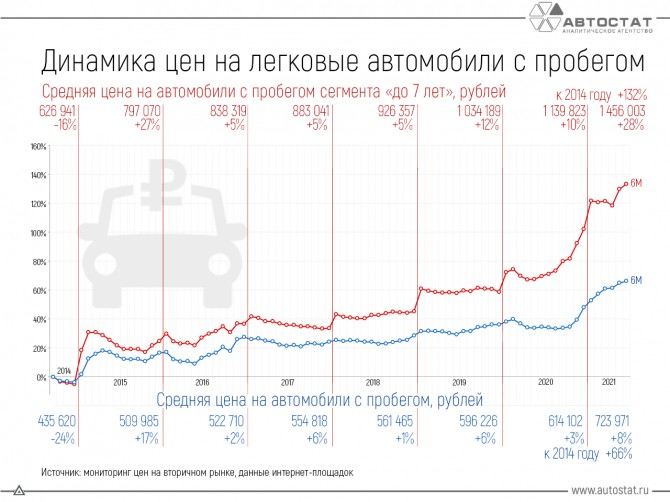

In [142]:
image_url_1='https://www.autostat.ru/application/includes/blocks/big_photo/images/cache/000/094/996/aba1c0d9-670-0.jpg'
Image(image_url_1,width=700, height='auto')

## Сегмент: с пробегом до 7 лет

In [143]:
# Функция для смены цены (до 7 лет)
def before_7_years(df, year, percent):
    df.loc[(df.production_date > 2014) & (df.mileage != 0.0) & (
        df.pars_date == year), 'price'] = df['price'] + (df['price'] * percent)

In [144]:
# Данные авто за 2014 с пробегом до 7 лет и датой выпуска модели после 2014 по 2019
before_7_years(train, 2014, 0.48)
before_7_years(train, 2015, 0.37)
before_7_years(train, 2016, 0.32)
before_7_years(train, 2017, 0.27)
before_7_years(train, 2018, 0.22)
before_7_years(train, 2019, 0.10)

# Данные авто за 2021 с пробегом до 7 лет и датой выпуска модели после 2014 (-28%)
train_parsed.loc[(train_parsed.production_date > 2014) & (
                  train_parsed.mileage != 0.0), 'price'] = train_parsed['price'] - (train_parsed['price'] * 0.28)

In [145]:
# # Данные авто за 2014 с пробегом до 7 лет и датой выпуска модели после 2014 (48%)
# train.loc[(train.productionDate > 2014) & (
#     train.mileage != 0.0) & (train.pars_date == 2014), 'price'] = train['price'] + (train['price'] * 0.48)

# # Данные авто за 2015 с пробегом до 7 лет и датой выпуска модели после 2014 (37%)
# train.loc[(train.productionDate > 2014) & (
#     train.mileage != 0.0) & (train.pars_date == 2015), 'price'] = train['price'] + (train['price'] * 0.37)

# # Данные авто за 2016 с пробегом до 7 лет и датой выпуска модели после 2014 (32%)
# train.loc[(train.productionDate > 2014) & (
#     train.mileage != 0.0) & (train.pars_date == 2016), 'price'] = train['price'] + (train['price'] * 0.32)

# # Данные авто за 2017 с пробегом до 7 лет и датой выпуска модели после 2014 (27%)
# train.loc[(train.productionDate > 2014) & (
#     train.mileage != 0.0) & (train.pars_date == 2017), 'price'] = train['price'] + (train['price'] * 0.27)

# # Данные авто за 2018 с пробегом до 7 лет и датой выпуска модели после 2014 (22%)
# train.loc[(train.productionDate > 2014) & (
#     train.mileage != 0.0) & (train.pars_date == 2018), 'price'] = train['price'] + (train['price'] * 0.22)

# # Данные авто за 2019 с пробегом до 7 лет и датой выпуска модели после 2014 (10%)
# train.loc[(train.productionDate > 2014) & (
#     train.mileage != 0.0) & (train.pars_date == 2019), 'price'] = train['price'] + (train['price'] * 0.10)

## Сегмент: с пробегом после 7 лет

In [146]:
# Функция для смены цены (после 7 лет)
def after_7_years(df, year, percent):
    df.loc[(df.production_date < 2014) & (
               df.mileage != 0.0) & (df.pars_date == 2015), 'price'] = df['price'] + (df['price'] * percent)

In [147]:
after_7_years(train, 2014, 0.11)
after_7_years(train, 2015, 0.18)
after_7_years(train, 2016, 0.16)
after_7_years(train, 2017, 0.10)
after_7_years(train, 2018, 0.09)
after_7_years(train, 2019, 0.03)

# Данные авто за 2021 с пробегом после 7 лет и датой выпуска модели до 2014 (-8%)
train_parsed.loc[(train_parsed.production_date < 2014) & (
                  train_parsed.mileage != 0.0), 'price'] = train_parsed['price'] - (train_parsed['price'] * 0.8)

In [148]:
# # Данные авто за 2014 с пробегом и датой выпуска модели до 2014 (11%)
# train.loc[(train.productionDate < 2014) & (
#     train.mileage != 0.0) & (train.pars_date == 2014), 'price'] = train['price'] + (train['price'] * 0.11)

# # Данные авто за 2015 с пробегом и датой выпуска модели до 2014 (18%)
# train.loc[(train.productionDate < 2014) & (
#     train.mileage != 0.0) & (train.pars_date == 2015), 'price'] = train['price'] + (train['price'] * 0.18)

# # Данные авто за 2016 с пробегом и датой выпуска модели до 2014 (16%)
# train.loc[(train.productionDate < 2014) & (
#     train.mileage != 0.0) & (train.pars_date == 2016), 'price'] = train['price'] + (train['price'] * 0.16)

# # Данные авто за 2017 с пробегом и датой выпуска модели до 2014 (10%)
# train.loc[(train.productionDate < 2014) & (
#     train.mileage != 0.0) & (train.pars_date == 2017), 'price'] = train['price'] + (train['price'] * 0.10)

# # Данные авто за 2018 с пробегом и датой выпуска модели до 2014 (9%)
# train.loc[(train.productionDate < 2014) & (
#     train.mileage != 0.0) & (train.pars_date == 2018), 'price'] = train['price'] + (train['price'] * 0.09)

# # Данные авто за 2019 с пробегом и датой выпуска модели до 2014 (3%)
# train.loc[(train.productionDate < 2014) & (
#     train.mileage != 0.0) & (train.pars_date == 2019), 'price'] = train['price'] + (train['price'] * 0.03)

## Без пробега

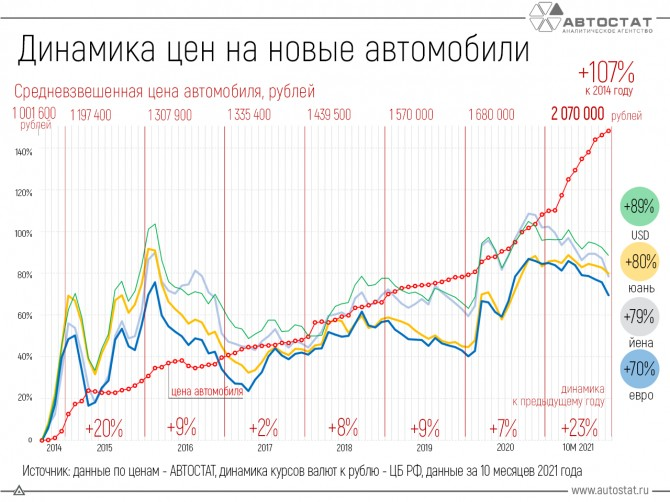

In [149]:
image_url_2='https://www.autostat.ru/application/includes/blocks/big_photo/images/cache/000/098/537/e44a2300-670-0.jpg'
Image(image_url_2,width=700, height='auto')

### Без пробега дата выупска после 2014

In [150]:
train.loc[(train.production_date > 2014) & (train.mileage == 0.0), 'pars_date'].unique()

array([2020, 2019, 2018], dtype=int64)

In [151]:
# Данные авто за 2018 без пробега и датой выпуска модели после 2014 (16%)
train.loc[(train.production_date > 2014) & (
    train.mileage == 0.0) & (train.pars_date == 2018), 'price'] = train['price'] + (train['price'] * 0.16)

# Данные авто за 2019 без пробега и датой выпуска модели после 2014 (7%)
train.loc[(train.production_date > 2014) & (
    train.mileage == 0.0) & (train.pars_date == 2019), 'price'] = train['price'] + (train['price'] * 0.07)

In [152]:
# Данные авто за 2021 без пробега и датой выпуска модели после 2014 (-23%) (train_parsed)
train_parsed.loc[(train_parsed.production_date > 2014) & (
    train_parsed.mileage == 0.0), 'price'] = train_parsed['price'] - (train_parsed['price'] * 0.23)

In [153]:
for df in [train, train_parsed]:
    df['price'] = round(df['price']).astype(np.int64)

<a id="Point_3"></a>
# 3. Анализ предобработанных данных, Feature Engineering и подготовка выборок.

In [154]:
train_original = train.copy()
train_parsed_original = train_parsed.copy()
test_original = test.copy()

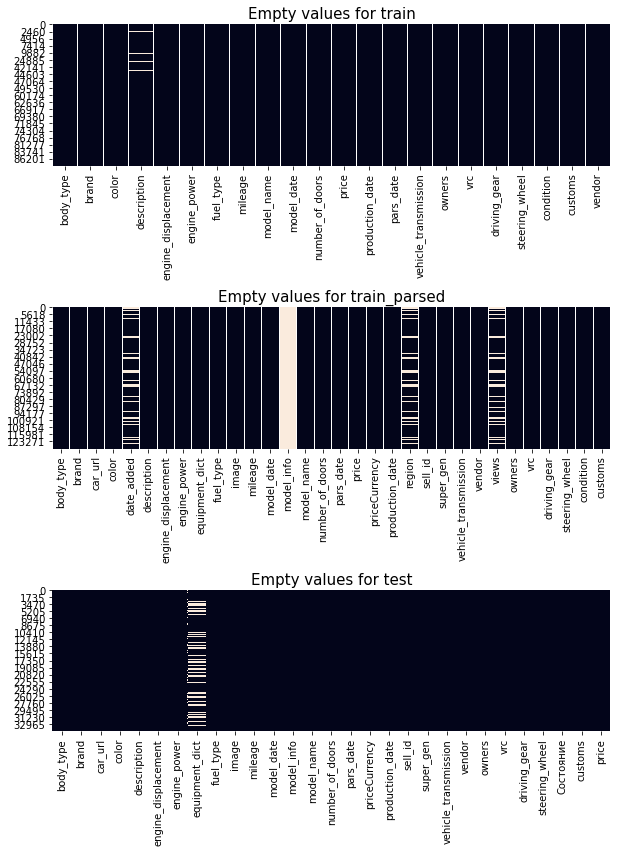

In [155]:
# Проверим отсутствующие значения в столбцах по датасетам
fig, axes = plt.subplots(3,1, figsize=(10, 13))
df_count = 0
df_name = ['train', 'train_parsed', 'test']
for df in [train, train_parsed, test]:
    sns.heatmap(df.isna(), ax=axes[df_count],
                    cbar = False)
    axes[df_count].set_title(f'Empty values for {df_name[df_count]}',
                          size=15)
    df_count += 1
plt.subplots_adjust(hspace=1);

In [156]:
# Возможность скинуть пустые значения, но качество метрики ухудшается, т.к. что оставляем
#train_parsed.dropna(subset = ['model_name'], axis= 0, inplace = True)

In [157]:
#train_parsed.drop(columns = ['views','date_added','region','image'], axis = 1, inplace = True)
#test.drop(['equipment_dict'], axis = 1, inplace = True)

In [158]:
#train_parsed.model_name.isna().value_counts()

## Избавление от дублей в train_parsed

In [159]:
# Меняем тип данных sell_id в train_parsed. Избавляемся от повторяющихся значений в датасете train_parsed.
train_parsed['sell_id'] = train_parsed.sell_id.astype(np.int64)
train_parsed = (train_parsed[~train_parsed.sell_id.isin(test.sell_id)])

# 3.1 Combined Dataset

Объединим два датасета, предварительно отбросив ненужные нам столбцы.

In [160]:
train.drop(['pars_date'], axis = 1, inplace = True)
train_parsed.drop(['car_url', 'date_added', 'equipment_dict',
                   'image', 'model_info', 'pars_date', 
                   'priceCurrency', 'super_gen', 'views',
                   'sell_id', 'region'], axis = 1, inplace = True)
test.drop(['car_url', 'equipment_dict', 'image', 
           'model_info', 'pars_date', 'priceCurrency', 'super_gen', 'sell_id'], axis = 1, inplace = True)

In [161]:
# Добавляем название датасетов, как отдельный признак, для дальнейшего разделения на тренировочную и валидационную выборки
train['dataset'] = 'train'
train_parsed['dataset'] = 'train_parsed'
test['dataset'] = 'test'

#Объединяем датасеты в новый
combined_train = pd.concat([train, train_parsed], ignore_index=True)
combined_train = pd.concat([combined_train, test], ignore_index=True)

#Сортируем столбцы
combined_train = combined_train.reindex(sorted(train.columns), axis=1)

In [162]:
combined_train_original = combined_train.copy()

### 1. Среднее значение для столбцов brand, model_name, body_type, engine_displacement, engine_power

In [163]:
for col in ['brand', 'model_name', 'body_type', 'engine_displacement', 'engine_power']:
    col_means = combined_train.groupby([col])['price'].mean().to_dict()
    combined_train[col + '_' + 'price'] = combined_train[col].apply(lambda x: col_means[x])

### 2. Логарифмирование

Проверим выбросы по признаку price и его распределение 

In [164]:
def check_quantile(df):
    q1 = np.quantile(df['price'], 0.25)
    q3 = np.quantile(df['price'], 0.75)
    IQR = q3 - q1
    left_bound = q1 - 1.5*IQR
    right_bound = q3 + 1.5*IQR
    left_under = len(df['price'][df['price'] < left_bound])
    right_above = len(df['price'][df['price'] > right_bound])
    print(f'Левая граница {left_bound}, Кол-во значений за границей: {left_under}')
    print(f'Правая граница {right_bound}, Кол-во значений за границей: {right_above}')
    
print('combined_train')
check_quantile(combined_train)

combined_train
Левая граница -2790920.0, Кол-во значений за границей: 0
Правая граница 5014200.0, Кол-во значений за границей: 11716


Выбросы есть 

Text(0.5, 1.0, 'Column Price Log')

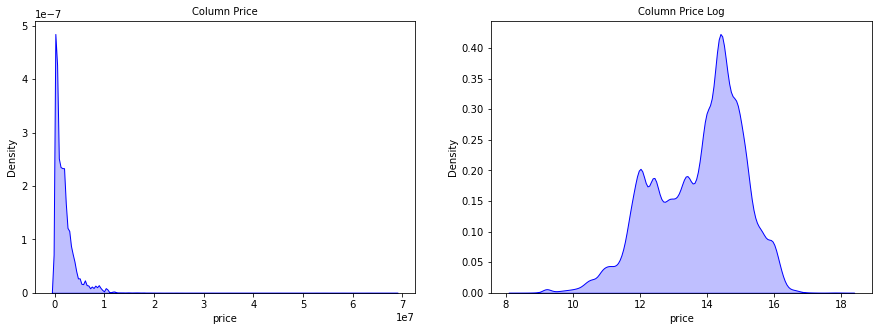

In [165]:
# Т.к.размах большой мы видим распределение, скошенное вправо (положительно ассиметричное)
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sns.kdeplot(combined_train[combined_train['dataset'] != 'test']['price'], ax = ax[0], color = 'b', shade = True)
#sns.distplot(train['price'], ax = ax[0], color = 'b')
ax[0].set_title('Column Price', size = 10)

# Приминив частный случай трансформации Бокса-Кокса, а именно логарифмирование к цене, 
# мы сможем привести признак к нормальному распределению
sns.kdeplot(np.log(combined_train[combined_train['dataset'] != 'test']['price'] + 1), ax = ax[1], color = 'b', shade = True)
#sns.distplot(np.log(train['price'] + 1), ax = ax[1], color = 'b')
ax[1].set_title('Column Price Log', size = 10)

In [166]:
combined_train['price_log'] = np.log(combined_train['price'] + 1)

### 3. Keywords percent in description

In [167]:
# Проверка на кол-во уникальных слов
def check_words(column):
    i = 0
    for cell in column:
        for mood in words:
            if mood == cell:
                i += 1
    return i

In [168]:
words = ['год выпуска', 'двигатель', 'привод ', 'стеклоподъемники', 'салон', 
         'коробка', 'кузов', 'резина' , 'диски', 
         'выхлоп', 'подушки', 'подушка', 'безопасности', 'птс', 'таможня',
        'обогрев', 'шины', 'фары', 'сидение', 'диагностики', 'комплектация',
        'блокировка', 'дверей', 'руля', 'руль', 'зеркал', 'запасное', 'документам',
        'документ']

In [169]:
for df in [combined_train]:    
    # Чтобы разделить предложение на составляющие слова внутри ячейки - преобразуемые некоторые значения.
    df['description_full'] = df['description'].apply(lambda x: (
    (((((((((((str(str(x).lower())
                   ).replace('\n•\t', ' ')
                    ).replace('\n', ' ')
                     ).replace('!', ' ')
                      ).replace('• ', ' ')
                       ).replace(':', ' ')
                        ).replace('.', ' ')
                         ).replace('-',' ')
                          ).replace(',',' ')
                           ).replace('  ',' ')
                            ).replace('  ',' ')
                             ).replace('  ',' ')
                              ))

    # Уберем пробелы слева и справа в описании.
    df['description_full'] = df['description_full'].apply(lambda x: (str(x).lstrip()).rstrip())

    # После чего разделим.
    df['description_split'] = df['description_full'].apply(lambda x: str(x).split(' '))

    # Посчитаем кол-во слов в описании. 
    df['description_count'] = df['description_split'].apply(lambda x: len(x))

    # Посчитаем кол-во ключевых слов
    df['description_key_words'] = df['description_split'].apply(check_words)

    # Посчитаем "процент" ключевых слов
    #df['description_percent'] = round((df['description_key_words'] * 100) / df['description_count']).astype(np.int64)

    # Удаляем ненужные столбцы
    df.drop(['description_split', 'description_count'], axis = 1, inplace = True)

<AxesSubplot:xlabel='description_key_words', ylabel='Density'>

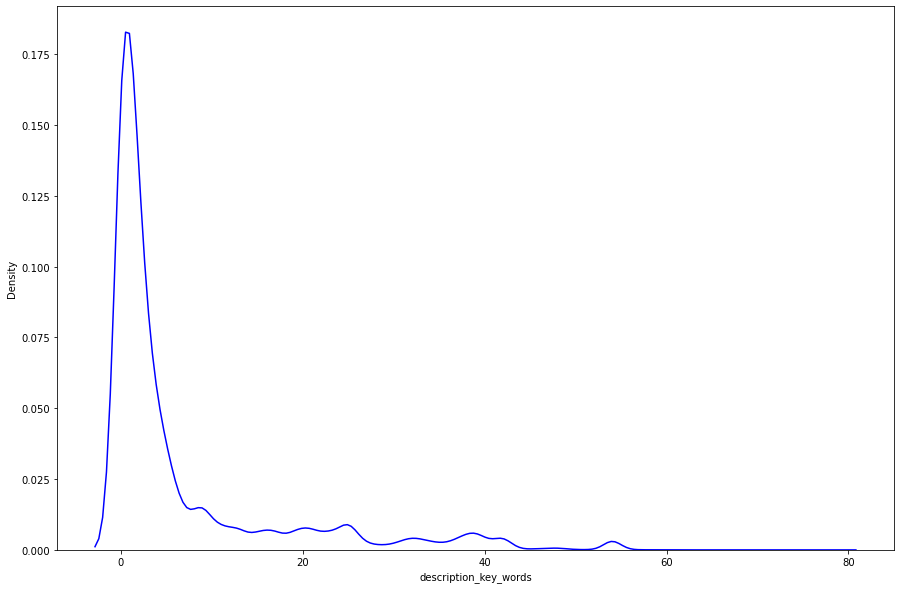

In [170]:
fig, ax = plt.subplots(1, figsize = (15, 10))
sns.kdeplot(combined_train['description_key_words'], ax = ax, color = 'b', shade = False)

### 4. Токенизация слов

In [171]:
# Copying description feature
text_feature = combined_train['description_full'].copy()
# Removing numbers from the text
# text_feature = text_feature.str.replace(r'\d+', '')
# Defining useless stop words
stop_words = stopwords.words('russian')

# Tokenization
tokenizer = CountVectorizer(stop_words=stop_words).build_analyzer()
tokenized_text_feature = text_feature.apply(tokenizer)

# Description legnth as a new feature
combined_train['description_length'] = tokenized_text_feature.apply(len)

# # Bag of words approach with word counts
# count_vec = CountVectorizer(stop_words=stop_words, max_features=50)
# count_text_feature = count_vec.fit_transform(text_feature).toarray()

# TF-IDF - reduced MAPE by ~0.7%
tf_idf = TfidfVectorizer(max_features=50, stop_words=stop_words)
tf_idf_feature = tf_idf.fit_transform(text_feature).toarray()
# Reducing dimensions of our tf_idf matrix
pca_tfidf = PCA(n_components=2, random_state=0)
tf_idf_pc = pca_tfidf.fit_transform(tf_idf_feature)

In [172]:
combined_train.drop(['description_full'], axis = 1, inplace = True)

In [173]:
combined_train.drop(['description'], axis = 1, inplace = True)

# 3.2 Классификация перемен

In [174]:
combined_train.columns

Index(['body_type', 'brand', 'color', 'condition', 'customs', 'dataset',
       'driving_gear', 'engine_displacement', 'engine_power', 'fuel_type',
       'mileage', 'model_date', 'model_name', 'number_of_doors', 'owners',
       'price', 'production_date', 'steering_wheel', 'vehicle_transmission',
       'vendor', 'vrc', 'brand_price', 'model_name_price', 'body_type_price',
       'engine_displacement_price', 'engine_power_price', 'price_log',
       'description_key_words', 'description_length'],
      dtype='object')

In [175]:
#Разделяем по классификации переменные

#бинарные переменные 
bin_cols = ['condition', 'customs', 'steering_wheel', 'vrc', 'vendor']

#категориальные переменные 
cat_cols = ['body_type', 'brand', 'color', 
            'fuel_type', 'model_name', 'number_of_doors', 
            'vehicle_transmission', 'driving_gear']

#числовые переменные 
num_cols = ['engine_displacement', 'engine_power', 'mileage', 
            'model_date', 'production_date',
                'brand_price', 'model_name_price', 'body_type_price', 
                'engine_displacement_price', 'engine_power_price', 'price_log', 
                'description_key_words', 'description_length']

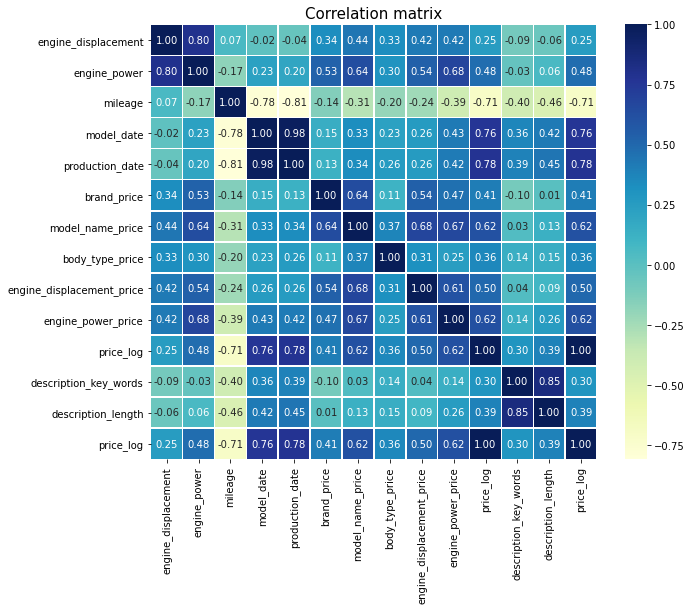

In [176]:
#Корреляция Пирсона
plt.figure(figsize = (10, 8))
sns.heatmap(combined_train[combined_train['dataset'] != 'test'][num_cols + ['price_log']].corr(), annot=True,
            fmt='.2f', cmap='YlGnBu', linewidth=0.5)
plt.title('Correlation matrix', size=15);

In [177]:
combined_train.columns

Index(['body_type', 'brand', 'color', 'condition', 'customs', 'dataset',
       'driving_gear', 'engine_displacement', 'engine_power', 'fuel_type',
       'mileage', 'model_date', 'model_name', 'number_of_doors', 'owners',
       'price', 'production_date', 'steering_wheel', 'vehicle_transmission',
       'vendor', 'vrc', 'brand_price', 'model_name_price', 'body_type_price',
       'engine_displacement_price', 'engine_power_price', 'price_log',
       'description_key_words', 'description_length'],
      dtype='object')

## Проверяем p-value между численными признаками и логнормальной ценой с поправкой Бонферрони

In [178]:
for col in num_cols:
    p_value = pearsonr(combined_train[combined_train['dataset'] != 'test'][col], 
                       combined_train[combined_train['dataset'] != 'test']['price_log'])[1]
    # Using Bonferonni correction as well
    if p_value < 0.05/(len(num_cols)):
        print(f'P-value={p_value} => "{col}" and price are correlated')

P-value=0.0 => "engine_displacement" and price are correlated
P-value=0.0 => "engine_power" and price are correlated
P-value=0.0 => "mileage" and price are correlated
P-value=0.0 => "model_date" and price are correlated
P-value=0.0 => "production_date" and price are correlated
P-value=0.0 => "brand_price" and price are correlated
P-value=0.0 => "model_name_price" and price are correlated
P-value=0.0 => "body_type_price" and price are correlated
P-value=0.0 => "engine_displacement_price" and price are correlated
P-value=0.0 => "engine_power_price" and price are correlated
P-value=0.0 => "price_log" and price are correlated
P-value=0.0 => "description_key_words" and price are correlated
P-value=0.0 => "description_length" and price are correlated


## One-Way ANOVA

In [179]:
dummy_cats = pd.get_dummies(combined_train[combined_train['dataset'] != 'test'][cat_cols + ['price_log']],
                            columns=cat_cols,
                            drop_first=True)
dummy_cats.shape

(158218, 590)

In [180]:
train_df = combined_train[combined_train['dataset'] != 'test'].copy()

for column in cat_cols + bin_cols:
    if train_df[column].nunique() > 533:
        ten_random_categories = np.random.choice(train_df[column].unique(), 10, replace=False)
        combs = list(combinations(ten_random_categories, 2))
    else:
        combs = list(combinations(train_df[column].unique(), 2))
    for pair in combs:
        p_value = f_oneway(train_df[train_df[column] == pair[0]]['price_log'],
                           train_df[train_df[column] == pair[1]]['price_log']).pvalue
        #print(len(combs))
        if p_value < (0.05/len(combs)):
            print(f'"{column}" feature is statistically significant')
            # Stopping the loop because at least one pair of group means differs
            break

"body_type" feature is statistically significant
"brand" feature is statistically significant
"color" feature is statistically significant
"fuel_type" feature is statistically significant
"model_name" feature is statistically significant
"number_of_doors" feature is statistically significant
"vehicle_transmission" feature is statistically significant
"driving_gear" feature is statistically significant
"condition" feature is statistically significant
"customs" feature is statistically significant
"vrc" feature is statistically significant
"vendor" feature is statistically significant


Как и другие параметрические тесты, дисперсионный анализ предполагает, что данные соответствуют нормальному распределению. Хорошим примером служит признак steering_wheel. При логнормальной цены мы *не отвергаем* нулевую гиптозу для признака, отвергая тем самым статическую значимость этого признака, но при использовании оргинальной цены мы получаем обратный результат. 

Хотя и исследования с использованием различных ненормальных распределений показали, что на частоту ложноположительных ответов это нарушение не сильно влияет (Glass et al. 1972, Harwell et al. 1992, Lix et al. 1996), предлагаю провести индивидуальный расчет для признака steering_wheel. Учитывая кол-во групп, мы взглянем на распределение Стьюдента.

## Способ 1

In [181]:
original_combined_train = combined_train.copy()
combined_train = combined_train[combined_train['dataset'] != 'test']
def check_t_and_anova(col_1, col_2):
    groups = combined_train[col_1].unique()
    ttest = []
    ftest = []
    df_between = len(combined_train[col_1].unique()) - 1
    df_within = len(combined_train[col_2]) - 2
    df_total = df_between + df_within
    f_critic = stats.f.ppf(1-0.05, df_between, df_within)

    for index_1, value_1 in enumerate(groups):
        for index_2, value_2 in enumerate(groups):
            if index_2 > index_1:
                group_1 = combined_train[combined_train[col_1] == value_1][col_2]
                group_2 = combined_train[combined_train[col_1] == value_2][col_2]

                t, p = ttest_ind(group_1, group_2)
                ttest.append([f'{value_1} - {value_2}:', round(t, 4), round(p, 4)])
                
                group_1_mean = group_1.mean()
                group_2_mean = group_2.mean()
                total_sum = (sum(group_1) + sum(group_2)) / (len(group_1) + len(group_2))

                sst = sum((group_1 - total_sum)**2) + sum((group_2 - total_sum)**2)
                ssw = sum((group_1 - group_1_mean)**2) + sum((group_2 - group_2_mean)**2)
                ssb = sst - ssw

                msb = ssb / df_between
                msw = ssw / df_within
                f = msb / msw
                if f < f_critic:
                    ftest.append([f'{value_1} - {value_2}:', round(f, 4), round(f_critic, 4)])

    threshold = 0.05/len(ttest)
    for t in ttest:
        if t[2] > (threshold):
            print(f'T-value: {t[1]}, p-value: {t[2]}, T-critical: {round(stats.t.ppf(1-0.05, df_total), 4)}')

In [182]:
check_t_and_anova('steering_wheel', 'price_log')

T-value: 0.6178, p-value: 0.5367, T-critical: 1.6449


Как мы видим, Т-распределение меньше, чем Т-критическое.
P-value, в свою очередь, превышает значение альфа (с поправкой Бонферрони).
Тем самым мы не отвергаем нулевую гипотезу.

## Способ 2

In [183]:


tukey = pairwise_tukeyhsd(endog=combined_train['price_log'],
                          groups=combined_train['steering_wheel'],
                          alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
left,right,-0.0077,0.5413,-0.0321,0.0167,False


## Способ 3

In [184]:
price_log = np.array(combined_train['price_log'])
#steering_wheel = np.array(combined_train['steering_wheel'].apply(lambda x: 1 if str(x) == 'right' else 0))
steering_wheel = np.array(combined_train['steering_wheel'])

new = ols('price_log ~ steering_wheel', data=combined_train).fit()
an = sm.stats.anova_lm(new, typ = 2)
an

,sum_sq,df,F,PR(>F)
steering_wheel,0.665497,1.0,0.381678,0.536707
Residual,275866.961487,158216.0,NaN,NaN


In [185]:
combined_train = original_combined_train.copy()
# Судя по корреляции лучше избавиться от model_date, т.к. выпуск важнее.
combined_train.drop('model_date', axis = 1, inplace = True)
#test.drop('model_date', axis = 1, inplace = True)

#числовые переменные
num_cols.remove('model_date')

In [186]:
features_cols = ['brand_price', 'model_name_price', 'body_type_price',
                 'engine_displacement_price', 'engine_power_price']

In [187]:
num_cols.remove('price_log')

<AxesSubplot:>

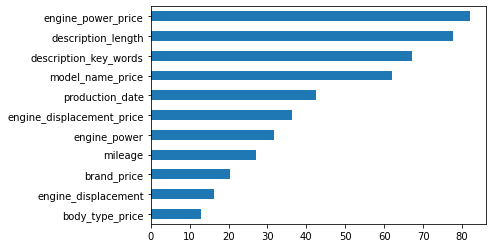

In [188]:
#Используем функцию f_classif для анализа значимости признака для нашей линейной модели
imp_num = pd.Series(f_classif(combined_train[combined_train['dataset'] != 'test'][num_cols], combined_train[combined_train['dataset'] != 'test']['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# 3.3 Выбросы

### Будем использовать IQR (Интерквартильный размах) и Z-score

In [189]:
for col in combined_train[combined_train['dataset'] != 'test'][num_cols]:
    quantile(combined_train[combined_train['dataset'] != 'test'], col)
    z_score_outlier(combined_train[combined_train['dataset'] != 'test'], col)
    print()

"engine_displacement" has 182 low outliers and 4298 high outliers. Sum: 4480
"engine_displacement" Z-score shows 3679 outliers

"engine_power" has 0 low outliers and 5863 high outliers. Sum: 5863
"engine_power" Z-score shows 3703 outliers

"mileage" has 0 low outliers and 2454 high outliers. Sum: 2454
"mileage" Z-score shows 1712 outliers

"production_date" has 5581 low outliers and 0 high outliers. Sum: 5581
"production_date" Z-score shows 2526 outliers

"brand_price" has 0 low outliers and 0 high outliers. Sum: 0
"brand_price" Z-score shows 0 outliers

"model_name_price" has 0 low outliers and 13342 high outliers. Sum: 13342
"model_name_price" Z-score shows 4955 outliers

"body_type_price" has 19 low outliers and 0 high outliers. Sum: 19
"body_type_price" Z-score shows 0 outliers

"engine_displacement_price" has 0 low outliers and 9629 high outliers. Sum: 9629
"engine_displacement_price" Z-score shows 3229 outliers

"engine_power_price" has 0 low outliers and 5211 high outliers. Sum:

D:\Users\leoge\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


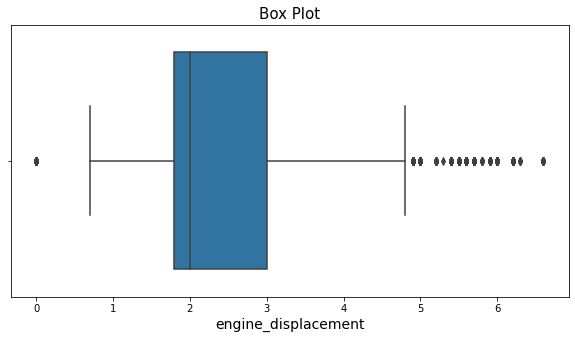

D:\Users\leoge\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


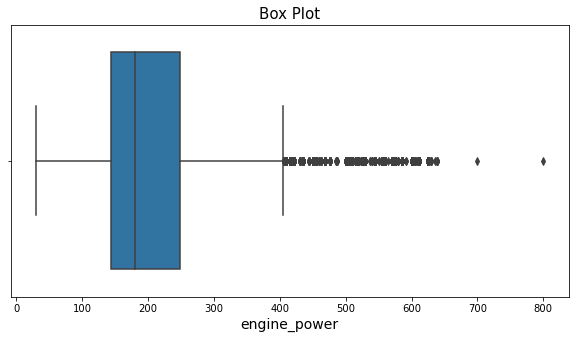

D:\Users\leoge\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


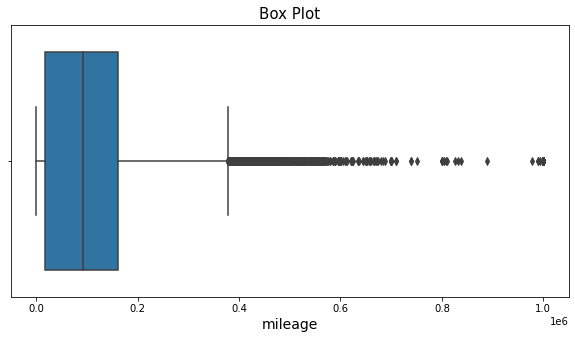

D:\Users\leoge\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


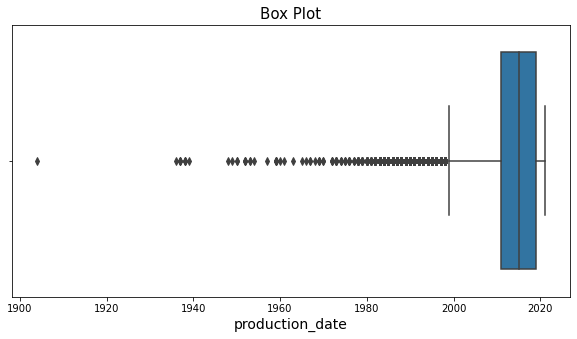

D:\Users\leoge\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


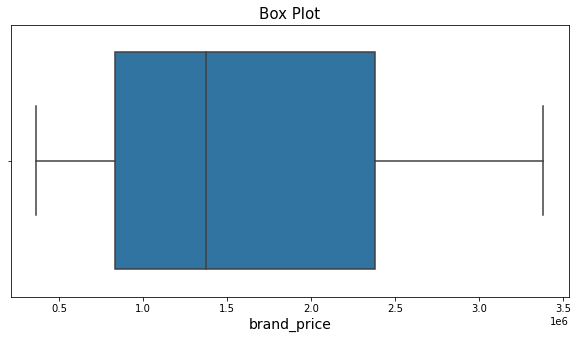

D:\Users\leoge\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


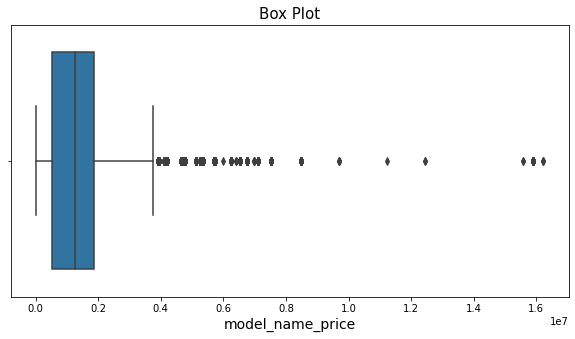

D:\Users\leoge\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


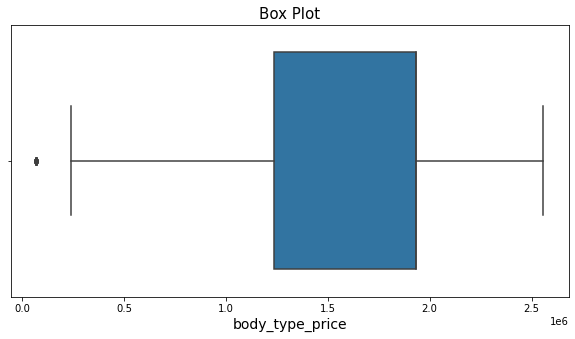

D:\Users\leoge\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


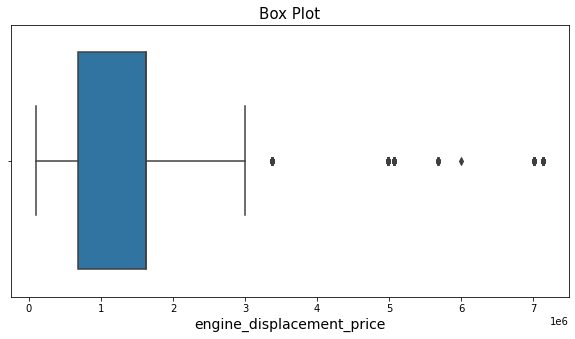

D:\Users\leoge\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


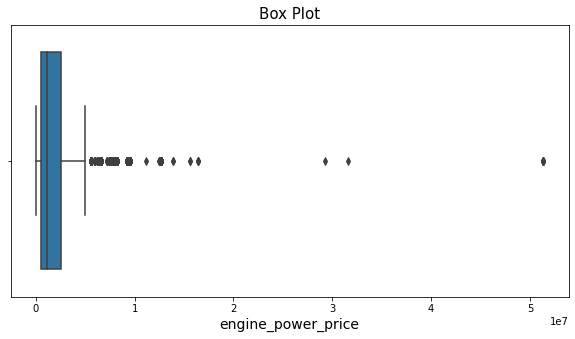

D:\Users\leoge\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


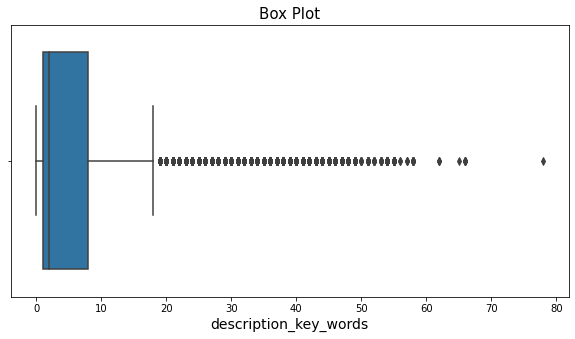

D:\Users\leoge\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


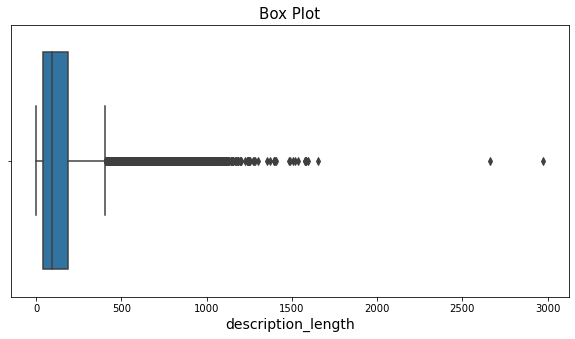

In [190]:
for col in combined_train[combined_train['dataset'] != 'test'][num_cols]:
    boxplot(combined_train[combined_train['dataset'] != 'test'], col)

In [191]:
# Наличие выбросов типично в датасетах, но в отличие от ошибочных выборосов входе наполнения датасета -
# наши выбросы являются натуральными. Избавляться от них не стоит.

# 3.4 Визуализация для бинарных и категориальных признаков

<ipython-input-192-966b310e1850>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  show_boxplot(data=combined_train[combined_train['dataset'] != 'test'][


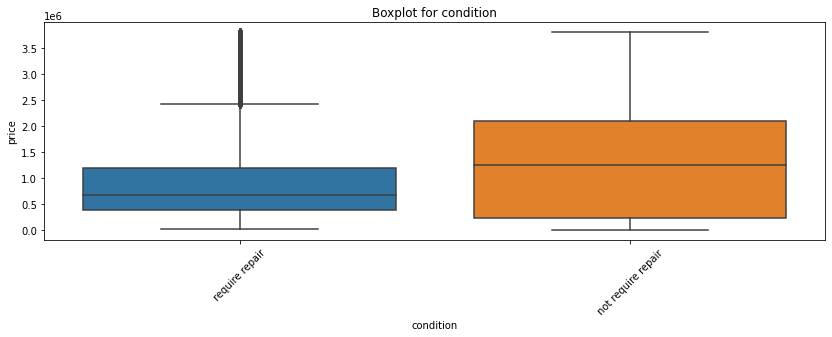

<ipython-input-192-966b310e1850>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  show_boxplot(data=combined_train[combined_train['dataset'] != 'test'][


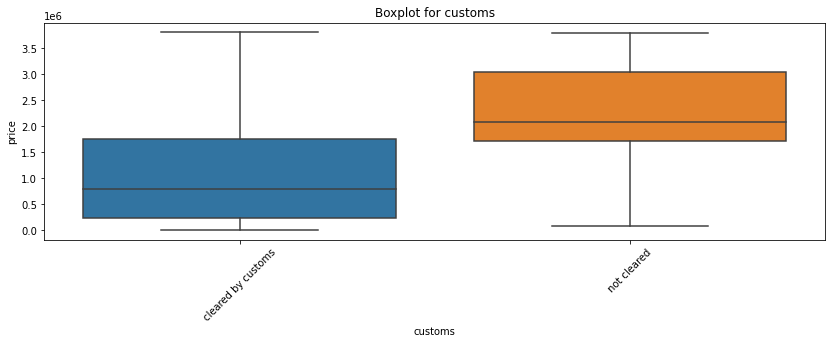

<ipython-input-192-966b310e1850>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  show_boxplot(data=combined_train[combined_train['dataset'] != 'test'][


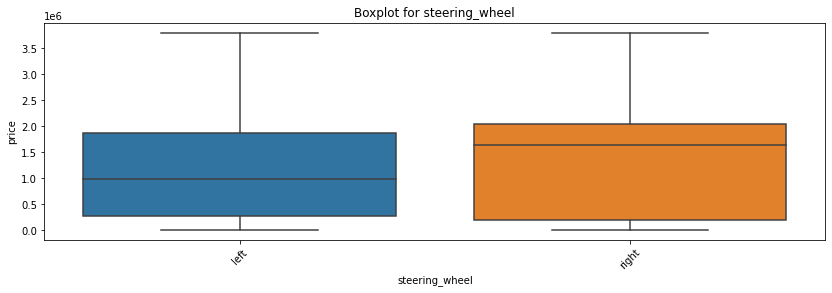

<ipython-input-192-966b310e1850>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  show_boxplot(data=combined_train[combined_train['dataset'] != 'test'][


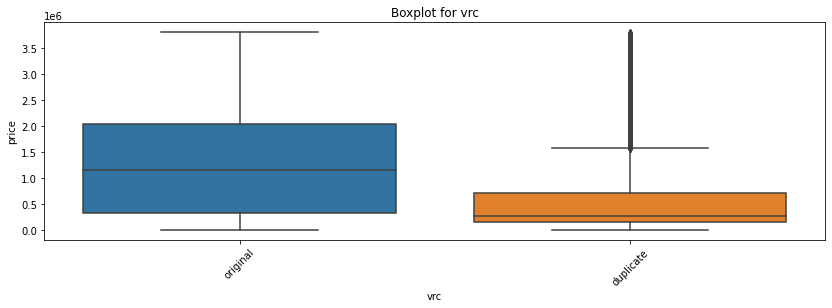

<ipython-input-192-966b310e1850>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  show_boxplot(data=combined_train[combined_train['dataset'] != 'test'][


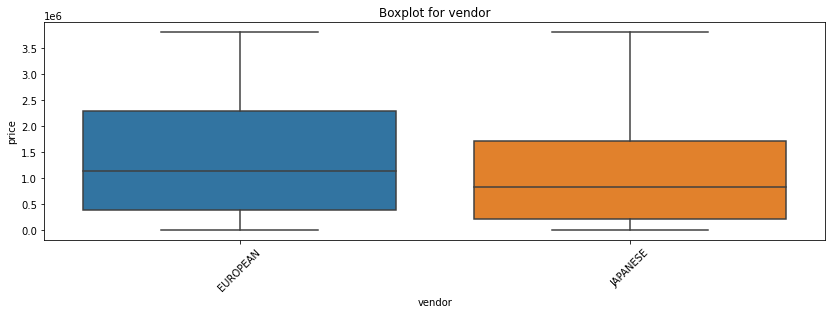

<ipython-input-192-966b310e1850>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  show_boxplot(data=combined_train[combined_train['dataset'] != 'test'][


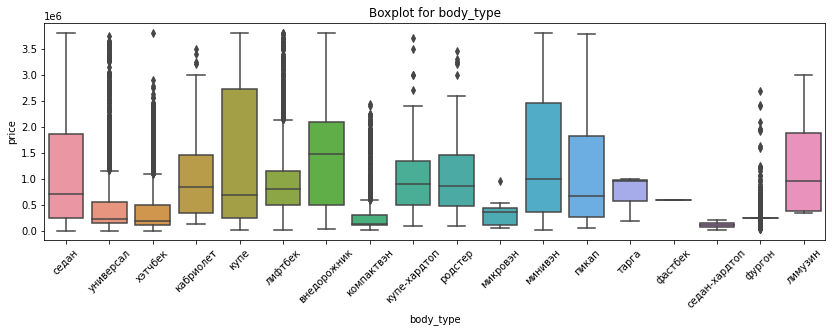

<ipython-input-192-966b310e1850>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  show_boxplot(data=combined_train[combined_train['dataset'] != 'test'][


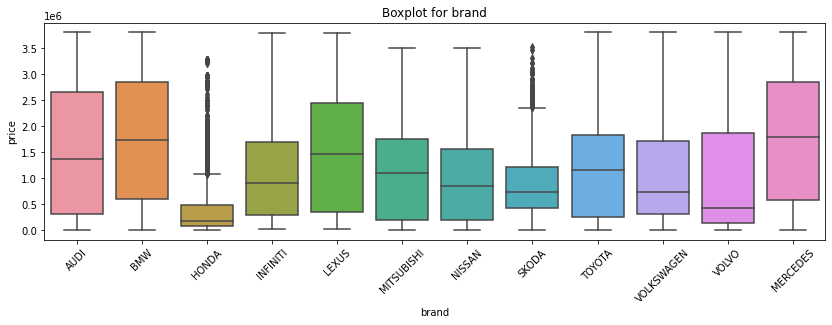

<ipython-input-192-966b310e1850>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  show_boxplot(data=combined_train[combined_train['dataset'] != 'test'][


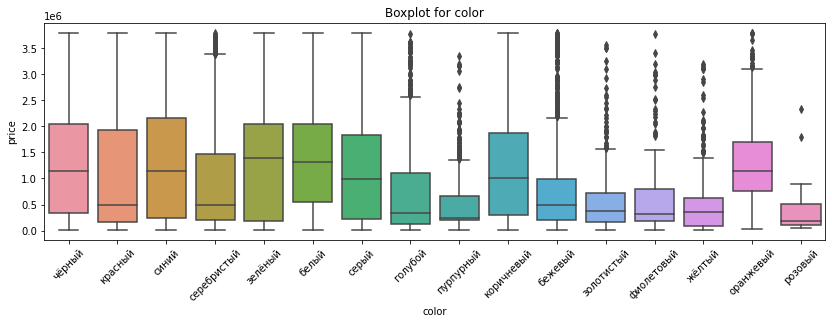

<ipython-input-192-966b310e1850>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  show_boxplot(data=combined_train[combined_train['dataset'] != 'test'][


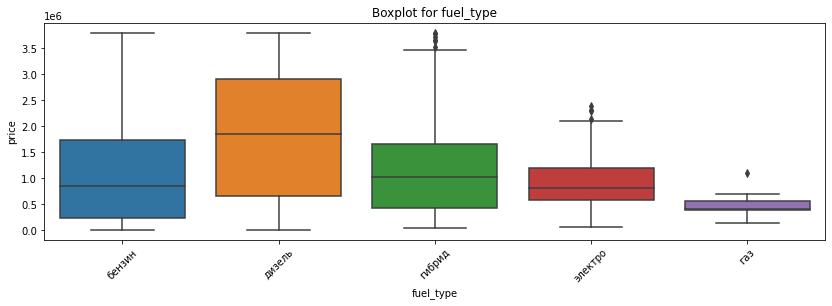

<ipython-input-192-966b310e1850>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  show_boxplot(data=combined_train[combined_train['dataset'] != 'test'][


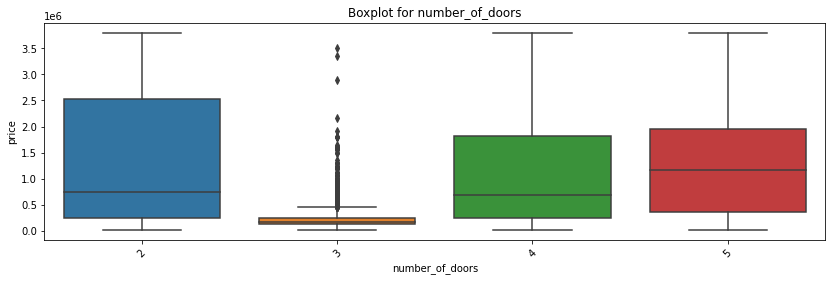

<ipython-input-192-966b310e1850>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  show_boxplot(data=combined_train[combined_train['dataset'] != 'test'][


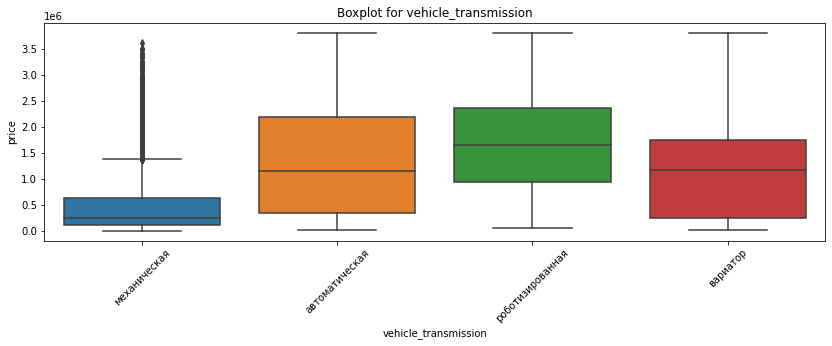

<ipython-input-192-966b310e1850>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  show_boxplot(data=combined_train[combined_train['dataset'] != 'test'][


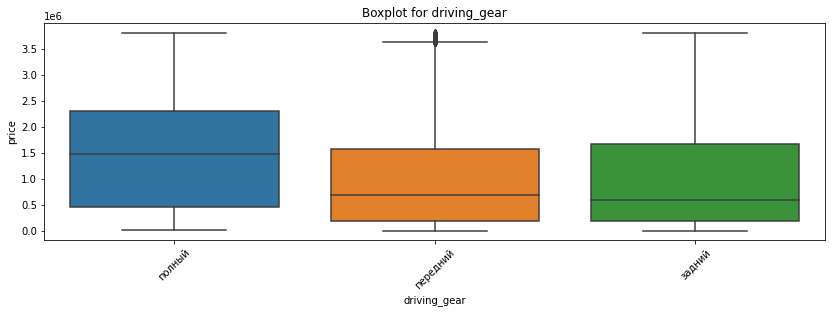

In [192]:
for col in bin_cols + cat_cols:
    if col not in ['model_name']:
        show_boxplot(data=combined_train[combined_train['dataset'] != 'test'][
            combined_train.price <= combined_train.price.quantile(0.9)], column=col, target_column='price')

In [193]:
# for col in bin_cols + cat_cols:
#     if col not in ['model_name']:
#         show_boxplot(data=combined_train, column=col, target_column='price')

In [194]:
df = combined_train[combined_train['dataset'] != 'test']

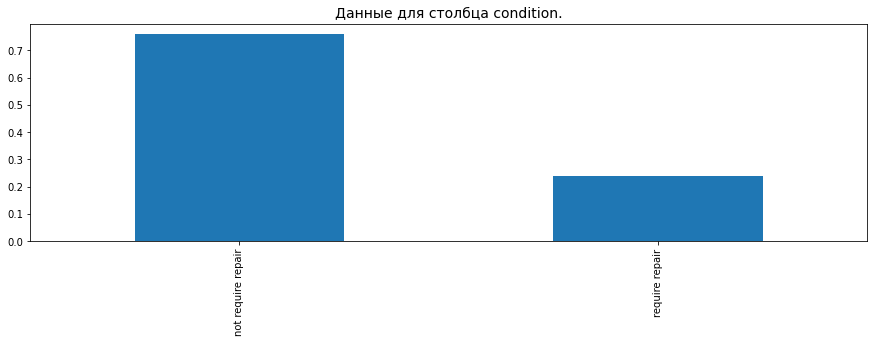

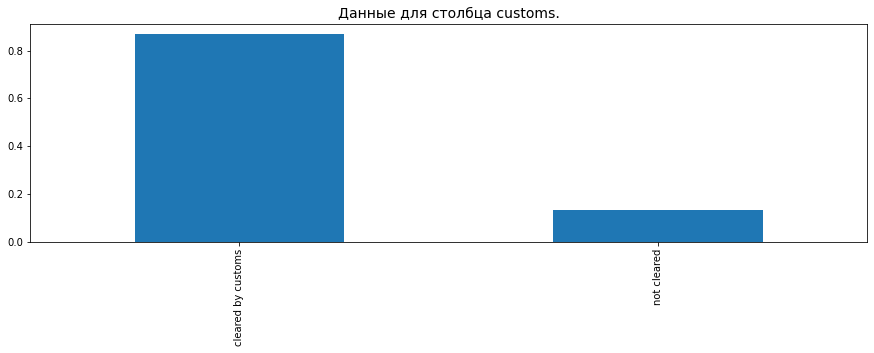

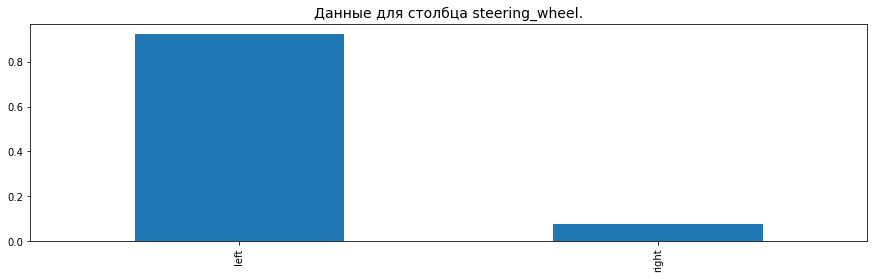

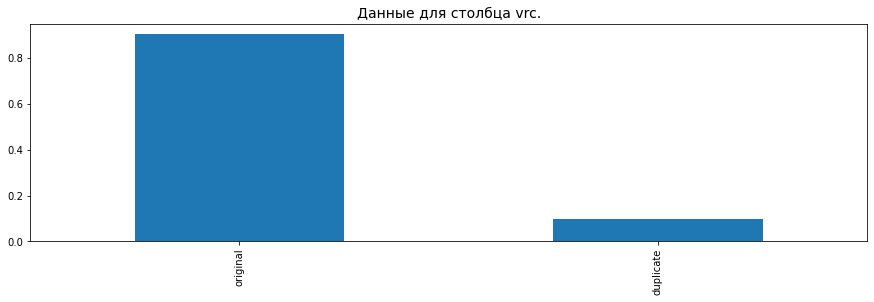

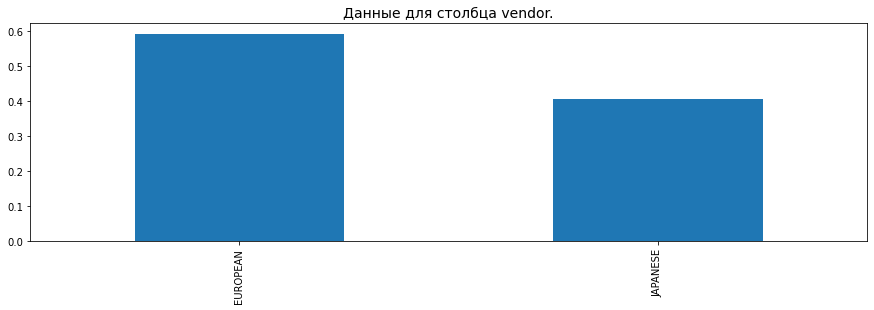

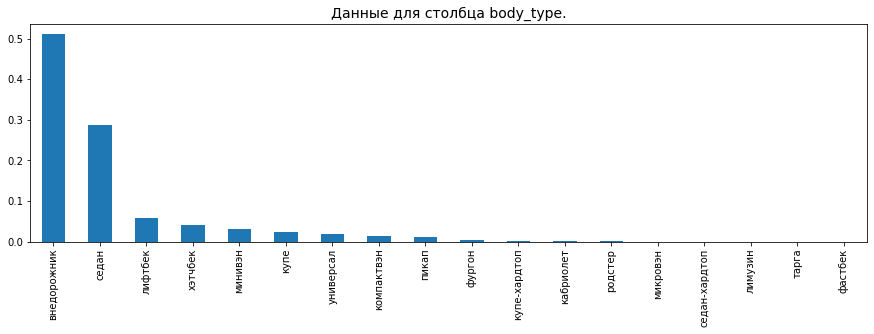

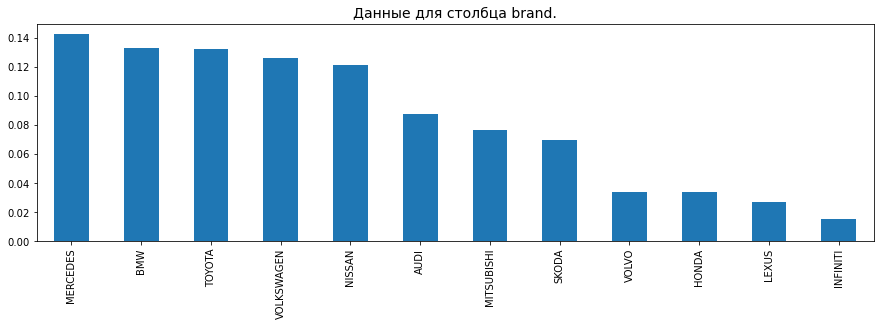

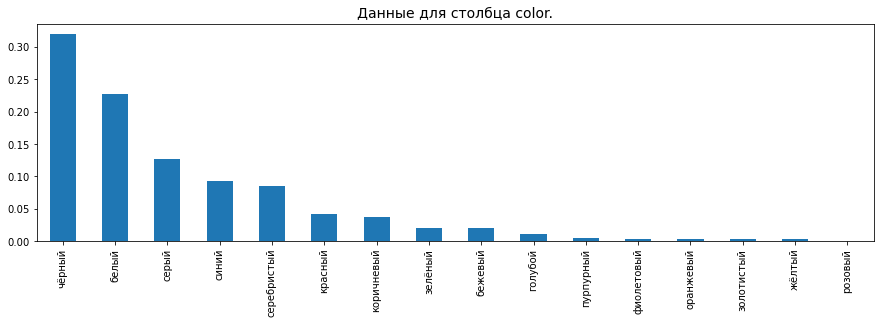

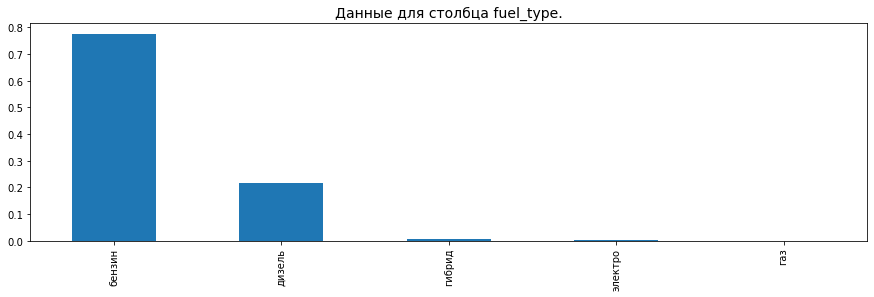

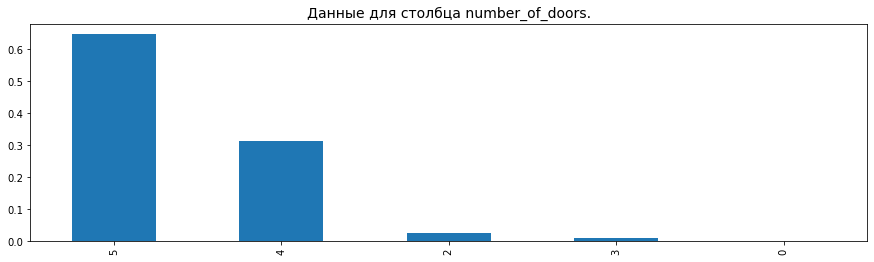

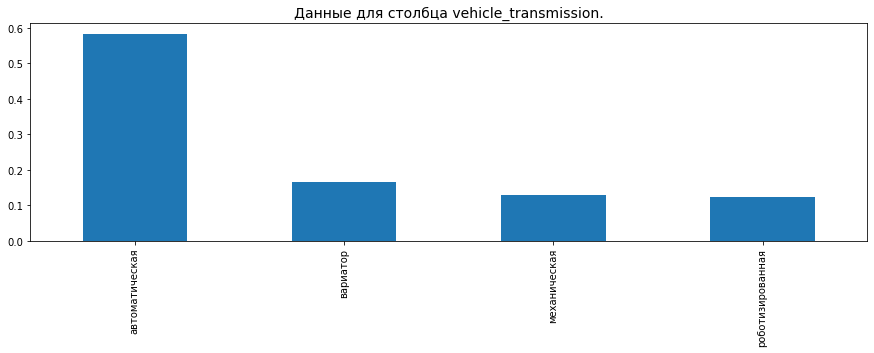

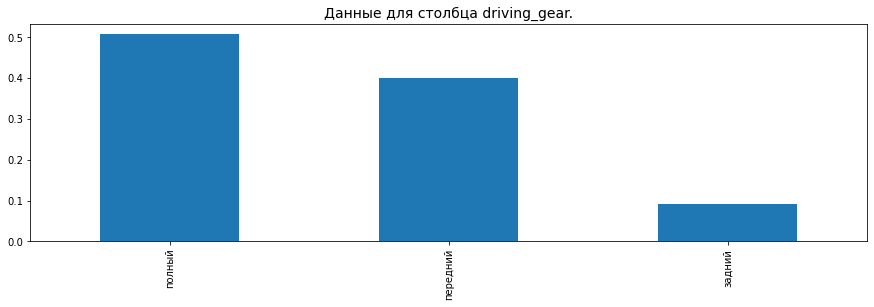

In [195]:
for col in bin_cols + cat_cols:
    if col not in ['model_name']:
        fig, ax = plt.subplots(figsize=(15, 4))
        ax.set_title(f'Данные для столбца {col}.', fontdict={'fontsize': 14})
        df[col].value_counts(normalize=True).plot(kind='bar', ax=ax)

# 3.5 Преобразование данных перед машинным обучением

In [196]:
# # Меняем значения в переменных
# df['vehicle_licence'] = df['vehicle_licence'].apply(lambda x: 1 if x == 'original' else 0)
# df['steering_wheel'] = df['steering_wheel'].apply(lambda x: 1 if x == 'left' else 0)
# df['vendor'] = df.vendor.apply(lambda x: 1 if x == 'EUROPEAN' else 0)
# df['customs'] = df['customs'].apply(lambda x: 1 if x == 'Растаможен' else 0)
# df['condition'] = df['condition'].apply(lambda x: 0 if x == 'Не требует ремонта' else 1).astype(np.int64)

In [197]:
#test_original = df.query('train == 0').drop(['train', 'price'], axis = 1)

In [198]:
# Для категориальных признаков мы будем использовать OneHotEncoder
# drop_dict = set()
# for e1, i1 in enumerate(combined_train[cat_cols]):
#     for e2, i2 in enumerate(combined_train[cat_cols]):
#         if e1 < e2:
#             onehot_encoder = OneHotEncoder() 
#             feature_array = onehot_encoder.fit_transform(combined_train[[i1, i2]]).toarray()
#             feature_labels = onehot_encoder.categories_
#             feature_labels = np.array(feature_labels).ravel()
#             feature_bin = pd.DataFrame(feature_array, columns = feature_labels)
#             combined_train = pd.concat([combined_train, feature_bin], axis = 1)
#             drop_dict.add(i1)
#             drop_dict.add(i2)
            
#combined_train = combined_train.loc[:,~combined_train.columns.duplicated()]
#combined_train = combined_train.drop(columns=list(drop_dict), axis = 1)

In [199]:
# Для категориальных признаков мы будем использовать OneHotEncoder

test_columns = combined_train.columns.values.tolist()
for col in combined_train[cat_cols]:
    combined_train = pd.get_dummies(combined_train, columns=[col])
test_columns_feature = combined_train.columns.values.tolist()
feature_columns = [x for x in test_columns_feature if not x in test_columns]
for col in combined_train[feature_columns]:
    combined_train[col] = combined_train[col].astype(np.int64)

In [200]:
combined_train.head()

,condition,customs,dataset,engine_displacement,engine_power,mileage,owners,price,production_date,steering_wheel,...,number_of_doors_3,number_of_doors_4,number_of_doors_5,vehicle_transmission_автоматическая,vehicle_transmission_вариатор,vehicle_transmission_механическая,vehicle_transmission_роботизированная,driving_gear_задний,driving_gear_передний,driving_gear_полный
0,require repair,cleared by customs,train,2.8,174,350000,3,200000,1991,left,...,0,1,0,0,0,1,0,0,0,1
1,require repair,cleared by customs,train,1.8,90,173424,3,60000,1986,left,...,0,1,0,0,0,1,0,0,1,0
2,require repair,cleared by customs,train,2.3,136,230000,3,99000,1989,left,...,0,0,1,0,0,1,0,0,0,1
3,require repair,cleared by customs,train,1.8,90,240000,3,65000,1989,left,...,0,1,0,0,0,1,0,0,1,0
4,require repair,cleared by customs,train,2.0,101,300000,3,100000,1991,left,...,0,1,0,0,0,1,0,0,1,0


In [201]:
# Для бинарных зададим значения вручную, чтобы отдать преимущество в пользу нужного значения
combined_train['condition'] = combined_train['condition'].apply(lambda x : 1 if str(x) == 'not require repair' else 0)
combined_train['customs'] = combined_train['customs'].apply(lambda x : 1 if str(x) == 'cleared by customs' else 0)
combined_train['steering_wheel'] = combined_train['steering_wheel'].apply(lambda x : 1 if str(x) == 'left' else 0)
combined_train['vrc'] = combined_train['vrc'].apply(lambda x : 1 if str(x) == 'original' else 0)
combined_train['vendor'] = combined_train['vendor'].apply(lambda x : 1 if str(x) == 'EUROPEAN' else 0)

In [202]:
for col in combined_train[bin_cols]:
    print(combined_train[col].unique())

[0 1]
[1 0]
[1 0]
[1 0]
[1 0]


In [203]:
# Для бинарных признаков будем использовать One Hot Encoding

# label_encoder = LabelEncoder()

# for col in bin_cols:
#     combined_train[col] = label_encoder.fit_transform(combined_train[col])
    
# # убедимся в преобразовании    
# combined_train.head()

<AxesSubplot:>

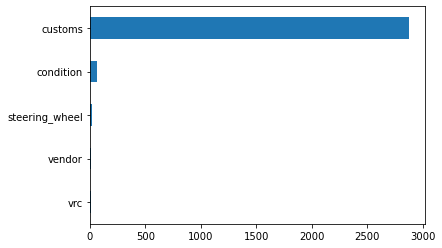

In [204]:
#Используем функцию f_classif для анализа значимости признака для нашей линейной модели
imp_num = pd.Series(f_classif(combined_train[bin_cols], combined_train['price'])[0], index = bin_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<a id="Point_4"></a>
# 4. Подготовка выборок

In [205]:
pre_combined_train = combined_train.copy()

In [206]:
combined_train['dataset'] = combined_train['dataset'].apply(lambda x : 1 if str(x) == 'train_parsed' else (2 if str(x) == 'train' else 0))

In [207]:
#Разделяем наши преобразованные данные на два датасета (тренировочный и тестовый)
train_data = combined_train.query('dataset != 0').drop(['dataset', 'price_log'], axis=1)
test_data = combined_train.query('dataset == 0').drop(['dataset', 'price', 'price_log'], axis=1)

In [208]:
#Создаем тренировочную и валидационную выборки
train, validation = train_test_split(train_data, test_size=0.3, random_state=RANDOM_SEED)

In [209]:
x_train = train.drop('price', axis = 1)
y_train = train['price'].astype(np.int32)

x_valid = validation.drop('price', axis = 1)
y_valid = validation['price'].astype(np.int32)

x_test = test_data.copy()

In [210]:
# Стандартизируем данные, определив в другую переменную
scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train)
x_valid_scaler = scaler.transform(x_valid)

x_test_scaler = scaler.transform(x_test)

<a id="Point_5"></a>
# 5. MachineLearning

### В качестве метрики для сравнения мы будем использовать MAPE (Mean Absolute Percentage Error)

# - Модель 1: Naive ML model

In [211]:
tmp_train = x_train.copy()
tmp_train['price'] = y_train
# Находим median по экземплярам всех переменных num_cols (другие показывают куда более хужший результат)

#оцениваем точность каждой переменной
for col in num_cols:
    y_pred = x_valid[col].map(tmp_train.groupby(col)['price'].median())
    print(f"The MAPE of the Naive model for {col}: {(np.mean(np.abs((y_pred-y_valid)/y_valid)) * 100):0.2f}%.")

The MAPE of the Naive model for engine_displacement: 214.99%.
The MAPE of the Naive model for engine_power: 154.48%.
The MAPE of the Naive model for mileage: 65.06%.
The MAPE of the Naive model for production_date: 62.95%.
The MAPE of the Naive model for brand_price: 286.55%.
The MAPE of the Naive model for model_name_price: 145.36%.
The MAPE of the Naive model for body_type_price: 237.60%.
The MAPE of the Naive model for engine_displacement_price: 214.99%.
The MAPE of the Naive model for engine_power_price: 154.48%.
The MAPE of the Naive model for description_key_words: 228.93%.
The MAPE of the Naive model for description_length: 167.37%.


#### Cудя по MAPE метрики - наивная модель МО нам не подходит.

# - Модель 2: CatBoost

In [212]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(x_train, y_train,
         eval_set=(x_valid, y_valid),
         verbose_eval=0,
         use_best_model=True)

y_pred = model.predict(x_valid)
# оцениваем точность
print(f"The MAPE of the CatBoost model: {(np.mean(np.abs((y_pred-y_valid)/y_valid)) * 100):0.2f}%.")

The MAPE of the CatBoost model: 10.80%.


#### CatBoost показал куда более лучший результат. 

# - Модель 3: RandomForest

In [213]:
# Без StandardScaler
myModel = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
myModel.fit(x_train, y_train)
y_pred = myModel.predict(x_valid)

print(f"The MAPE of the RandomForest model: {(np.mean(np.abs((y_pred-y_valid)/y_valid)) * 100):0.2f}%.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


The MAPE of the RandomForest model: 6.99%.


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.3s finished


In [214]:
# C StandardScaler
myModel = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
myModel.fit(x_train_scaler, y_train)
y_pred = myModel.predict(x_valid_scaler)

print(f"The MAPE of the RandomForest model: {(np.mean(np.abs((y_pred-y_valid)/y_valid)) * 100):0.2f}%.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


The MAPE of the RandomForest model: 6.98%.


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.3s finished


#### На данный момент лучший показатель.

### Остановка последующих тестирований - т.к. RandomForest показывает наилучший результат

# - Модель 4: ExtraTrees

In [215]:
# # with log-transformation of the target variable
# myModel = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)

# myModel.fit(x_train_scaler, y_train)
# y_pred = myModel.predict(x_valid_scaler)

# print(f"The MAPE of the ExtraTrees model: {(np.mean(np.abs((y_pred-y_valid)/y_valid)) * 100):0.2f}%.")

#### Хороший результат, но результат уступает случайному лесу.

# - Модель 5: Stacking

In [216]:
# # Создаем словарь с моделями, что будем использовать в качестве стекинга
# estimators = [
#     ('ran', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
#     ('ext',ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
#     ('xgb',XGBRegressor(objective='reg:squarederror', 
#                          colsample_bytree=0.5, 
#                          learning_rate=0.05, 
#                          max_depth=12, 
#                          alpha=1, 
#                          n_jobs=-1, 
#                          n_estimators=100, 
#                          random_state=RANDOM_SEED))]

In [217]:
# # Добавляем в качестве конечного алгоритма линейную регрессию
# stackingModel = StackingRegressor(
#      estimators=estimators,
#      final_estimator=LinearRegression())

In [218]:
# stackingModel.fit(x_train_scaler, y_train)
# y_pred = stackingModel.predict(x_valid_scaler)

# print(f"The MAPE of the Stacking model: {(np.mean(np.abs((y_pred-y_valid)/y_valid)) * 100):0.2f}%.")

#### Хороший результат, но и этот результат уступает случайному лесу.

## - Используем модель 3 в качестве предсказания

In [219]:
myModel = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
myModel.fit(x_train_scaler, y_train)

y_pred = myModel.predict(x_test_scaler)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.1s finished


In [220]:
#test_original
sample_submission = sample.copy()
sample_submission['price'] = y_pred

In [221]:
sample_submission.to_csv(f'sample_submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,621385.79
1,1100549428,880621.60
2,1100658222,984589.60
3,1100937408,743503.86
4,1101037972,656720.00
5,1100912634,743709.74
6,1101228730,625454.00
7,1100165896,391190.00
8,1100768262,1870706.01
9,1101218501,769693.00
